<a href="https://colab.research.google.com/github/michaelkinnas/HUA-DIT-Decision-Making-Systems-Semester-Project/blob/main/Copy_of_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Εργασία στα Συστήματα Λήψης Αποφάσεων

Ομάδες 3 ατόμων deadline: 18/6/2023

Στην παρούσα εργασία θα διαχειριστούμε και θα αναλύσουμε open και synthetic data για να εξάγουμε συμπεράσματα, να κάνουμε συστάσεις και να πάρουμε αποφάσεις για την επιλογή μουσικών συγκροτημάτων, καθώς και την αγορά/πώληση δίσκων. Για την εξαγωγή των opendata θα χρησιμοποιήσουμε το [Last.fm](https://www.last.fm/api) Music Discovery API [1] και/ή το [discogs API](https://www.discogs.com/developers) [2]

[1] https://www.last.fm/api

[2] https://www.discogs.com/developers


## Imports

In [ ]:
import networkx as nx
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
from google.colab import drive
drive.mount('/content/gdrive')
import requests
import time
import csv
import random

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

from scipy.stats import gibrat

Mounted at /content/gdrive


<ipython-input-1-c2afa80fbb27>:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## Εκφώνηση

Έστω ότι έχετε 20 users που σχηματίζουν ένα community όπως δίνεται από ένα Barabasi Albert model [3].

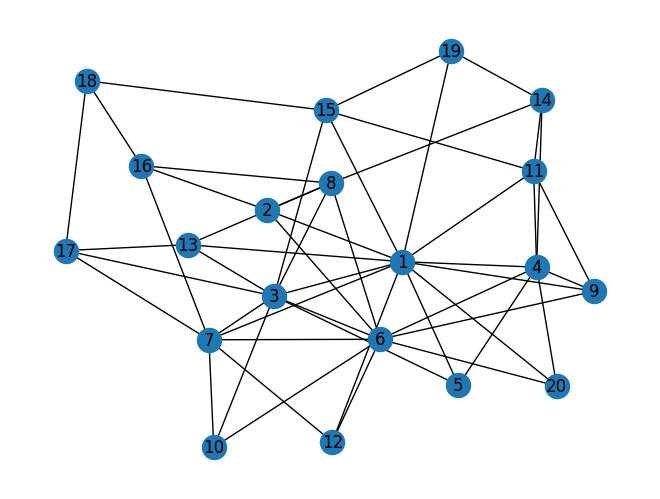

In [ ]:
community_graph= nx.barabasi_albert_graph(20,3)
mapping = {node: node + 1 for node in community_graph.nodes()}
community_graph = nx.relabel_nodes(community_graph, mapping)
nx.draw(community_graph, with_labels=True)

Generate random data for users in graph

#Database setup and functions

## DB Setup

Install mysql database

In [ ]:
# !apt update
# !apt upgrade
!apt-get install mysql-server > /dev/null

Start mysql db

In [ ]:
!service mysql start
!mysql -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH mysql_native_password BY 'root'"

 * Starting MySQL database server mysqld
su: warning: cannot change directory to /nonexistent: No such file or directory
   ...done.


Install python package

In [ ]:
!pip install mysql-connector-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 22.3 MB/s eta 0:00:00


Import DB stuff

In [ ]:
import mysql.connector
from mysql.connector import errorcode

In [ ]:
cnx = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="root"
)

cursor = cnx.cursor()

DB_NAME = 'music'

try:
  cursor.execute(f"CREATE DATABASE {DB_NAME} DEFAULT CHARACTER SET 'utf8'")
except mysql.connector.Error as err:
  print(err)
 # exit(1)

cursor.close()
cnx.close()

#create config var
DB_CONFIG = {
    'host':'localhost',
    'user':'root',
    'passwd':'root',
    'database':'music'
}

Create tables

In [ ]:
TABLES = {}
TABLES['users'] = '''
CREATE TABLE users (
	id int AUTO_INCREMENT,
	username varchar(255),
	money real,
	PRIMARY KEY(id)
);
'''

TABLES['artists'] = '''
CREATE TABLE artists (
	id int AUTO_INCREMENT,
	name varchar(255),
	genre varchar(255),
	PRIMARY KEY(id)
);
'''

# release_year DATE,
TABLES['albums'] = '''
CREATE TABLE albums (
	id int AUTO_INCREMENT,
	name varchar(255),
	artist_id int,
	price real,
	PRIMARY KEY(id),
	CONSTRAINT fk_albums_artists FOREIGN KEY (artist_id) REFERENCES artists(id) ON DELETE CASCADE
);
'''

TABLES['price_history'] = '''
CREATE TABLE price_history (
	album_id int,
	date VARCHAR(10),
	price real,
	CONSTRAINT fk_price_history_albums FOREIGN KEY (album_id) REFERENCES albums(id) ON DELETE CASCADE,
	CONSTRAINT pk_price_history PRIMARY KEY (album_id , date)
);
'''

TABLES['favourite_artists'] = '''
CREATE TABLE favourite_artists (
	user_id int,
	artist_id int,
	CONSTRAINT fk_favourite_artists_users FOREIGN KEY (user_id) REFERENCES users(id) ON DELETE CASCADE,
	CONSTRAINT fk_favourite_artists_artists FOREIGN KEY (artist_id) REFERENCES artists(id) ON DELETE CASCADE,
	CONSTRAINT pk_favourite_artists PRIMARY KEY (user_id , artist_id)
);
'''

TABLES['album_interests'] = '''
CREATE TABLE album_interests (
 	user_id int,
 	album_id int,
 	interest_coeff int,
 	CONSTRAINT fk_album_interests_users FOREIGN KEY (user_id) REFERENCES users(id) ON DELETE CASCADE,
 	CONSTRAINT fk_album_interests_albums FOREIGN KEY (album_id) REFERENCES albums(id) ON DELETE CASCADE,
	CONSTRAINT pk_album_interests PRIMARY KEY (user_id , album_id)
);
'''

TABLES['album_owners'] = '''
CREATE TABLE album_owners (
	user_id int,
	album_id int,
	CONSTRAINT fk_album_owners_users FOREIGN KEY (user_id) REFERENCES users(id) ON DELETE CASCADE,
	CONSTRAINT fk_album_owners_albums FOREIGN KEY (album_id) REFERENCES albums(id) ON DELETE CASCADE,
	CONSTRAINT pk_album_owners PRIMARY KEY (user_id , album_id)
);
'''

TABLES['friends'] = '''
CREATE TABLE friends (
	user_id int,
	friend_id int,
	CONSTRAINT pk_friends PRIMARY KEY (user_id , friend_id),
	CONSTRAINT fk_friends_users FOREIGN KEY (user_id) REFERENCES users(id) ON DELETE CASCADE,
	CONSTRAINT fk_friends_users_friend FOREIGN KEY (friend_id) REFERENCES users(id) ON DELETE CASCADE
);
'''

TABLES['tracks'] = '''
CREATE TABLE tracks (
	id int AUTO_INCREMENT,
	album_id int NOT NULL,
	track_name varchar(255),
	duration int,
	PRIMARY KEY(id),
	CONSTRAINT fk_tracks_albums FOREIGN KEY (album_id) REFERENCES albums(id) ON DELETE CASCADE
);
'''

def DB_create_tables():
	cnx = mysql.connector.connect(**DB_CONFIG)
	cursor = cnx.cursor()

	for key in TABLES:
		try:
			# print(f'Creating table {TABLES[key]}: ')
			cursor.execute(TABLES[key])
		except mysql.connector.Error as err:
			print(err)
			# exit(1)

	cursor.close()
	cnx.close()

In [ ]:
DB_create_tables()

In [ ]:
# DB_drop_tables()

## DB Inserts

In [ ]:
# DB Inserts

def DB_insert_user(username: str, money: float)-> int:
    """Insert a user to DB by his username

    :param username: The user's username
    :return: User's id
    """
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = "INSERT INTO users (username, money) VALUES (%s, %s)"
    values = (username, money)
    new_id = None
    try:
        cursor.execute(query, values)
        cnx.commit()
        new_id = cursor.lastrowid
        print(f"User {username} with ID: {new_id} got inserted!")
    except mysql.connector.Error as err:
        print("User insertion problem: ", err)
    finally:
        cursor.close()
        cnx.close()
        return new_id


# ARTISTS
def DB_insert_artist(artist_name: str, artist_genre: str)-> int:
    """Insert an artist to DB by his name

    :param artist_name: The artist's name
    :param artist_genre: The artist's music genre
    :return: Artist's id
    """

    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = "INSERT INTO artists (name, genre) VALUES (%s, %s)"
    values = (artist_name, artist_genre)
    new_id = None
    try:
        cursor.execute(query, values)
        cnx.commit()
        new_id = cursor.lastrowid
        print(f"Artist {artist_name} with ID: {new_id} got inserted!")
    except mysql.connector.Error as err:
        print("Artist insertion problem: ", err)
    finally:
        cursor.close()
        cnx.close()
        return new_id

# ALBUMS
def DB_insert_album(album_name: str, artist_id: int, price: float)-> int:
    """Insert an album to DB by its name and its artist's id

    :param album_name: The album's name
    :param artist_id: Album's artist id
    :return: Album's id
    """

    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = "INSERT INTO albums (name, artist_id, price) VALUES (%s, %s, %s)"
    values = (album_name, artist_id, price)
    new_id = None
    try:
        cursor.execute(query, values)
        cnx.commit()
        new_id = cursor.lastrowid
        print(f"Album {album_name} with ID: {new_id} got inserted!")
    except mysql.connector.Error as err:
        print("Album insertion problem: ", err)
    finally:
        cursor.close()
        cnx.close()
        return new_id

# FAVOURITE_ARTISTS
def DB_insert_favourite_artists(user_id: int, artist_id: int)-> None:
    """Insert a favourite artist to DB by the user's id and artist's id

    :param user_id: The user's id
    :param artist_id: The artist's id
    :return: None
    """

    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = "INSERT INTO favourite_artists (user_id, artist_id) VALUES (%s, %s)"
    values = (user_id, artist_id)
    try:
        cursor.execute(query, values)
        cnx.commit()
        print(f"User's {user_id} favorite_artists with ID: {artist_id} got inserted!")
    except mysql.connector.Error as err:
        print("Favorite artist insertion problem: ", err)
    finally:
        cursor.close()
        cnx.close()

# ALBUM_INTERESTS
def DB_insert_album_interests(user_id: int, album_id: int, interest_coeff: int)-> None:
    """Insert an album interest to DB by the user's id and album's id

    :param user_id: The user's id
    :param album_id: The album's id
    :return: None
    """

    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = "INSERT INTO album_interests (user_id, album_id, interest_coeff) VALUES (%s, %s, %s)"
    values = (user_id, album_id, interest_coeff)
    try:
        cursor.execute(query, values)
        cnx.commit()
        print(f"User's {user_id} album interest with ID: {album_id} got inserted!")
    except mysql.connector.Error as err:
        print("Album interest insertion problem: ", err)
    finally:
        cursor.close()
        cnx.close()

# OWNED_ALBUMS
def DB_insert_owned_albums(user_id: int, album_id: int)-> None:
    """Insert an owned album to DB by the user's id and album's id

    :param user_id: The user's id
    :param album_id: The album's id
    :return: None
    """

    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = "INSERT INTO album_owners (user_id, album_id) VALUES (%s, %s)"
    values = (user_id, album_id)
    try:
        cursor.execute(query, values)
        cnx.commit()
        print(f"User's {user_id} owned album with ID: {album_id} got inserted!")
    except mysql.connector.Error as err:
        print("Owned album insertion problem: ", err)
    finally:
        cursor.close()
        cnx.close()

# FRIENDS
def DB_insert_friends(user_id: int, friend_ids: list)-> None:
    """Insert a friend to DB by the user's id and friend's id

    :param user_id: The user's id
    :param friend_ids: A list with user ids
    :return: None
    """

    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()
    query = "INSERT INTO friends (user_id, friend_id) VALUES (%s, %s)"
    values = [(user_id, friend_id) for friend_id in friend_ids]
    try:
        cursor.executemany(query, values)
        cnx.commit()
        print(f"User's {user_id} friends got inserted!")
    except mysql.connector.Error as err:
        print("Friend insertion problem: ", err)
    finally:
        cursor.close()
        cnx.close()

# TRACKS
def DB_insert_tracks(track_list: list, album_id: int)-> None:
    """Insert a track to DB by the track name, duration and album's id

    :param track_dict: A list that contains track's name and track's duration
    :param album_id: The album's id
    :return: None
    """

    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()
    tracks = []
    durations = []
    for track in track_list:
        tracks.append(track["name"])
        durations.append(track["duration"])
    query = "INSERT INTO tracks (album_id, track_name, duration) VALUES (%s, %s, %s)"
    values = [(album_id, track_name, track_duration) for track_name, track_duration in zip(tracks, durations)]
    try:
        cursor.executemany(query, values)
        cnx.commit()
        print(f"Album's {album_id} tracks got inserted!")
    except mysql.connector.Error as err:
        print("Tracks insertion problem: ", err)
    finally:
        cursor.close()
        cnx.close()

def DB_insert_price_history(album_id, price_series):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = "INSERT INTO price_history (album_id, date, price) VALUES (%s, %s, %s)"
    values = [(album_id, str(date)[0:10], round(price,2)) for date, price in zip(price_series['date'], price_series['price'])]

    try:
        cursor.executemany(query, values)
        cnx.commit()
        print(f"Album's {album_id} price history was inserted!")
    except mysql.connector.Error as err:
        print("Price history insertion problem: ", err)
    finally:
        cursor.close()
        cnx.close()


## DB Selects


In [ ]:
# Define DB functions

def DB_find_user(username):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    cursor.execute(f'SELECT * FROM users WHERE username = "{username}"')

    for item in cursor:
        return item[0]

    cursor.close()
    cnx.close()


def DB_find_artist(artist_name):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    if "'" in artist_name:
        query = f'SELECT id FROM artists WHERE name = "{artist_name}"'
    else:
        query = f"SELECT id FROM artists WHERE name = '{artist_name}'"

    try:
        cursor.execute(query)
        result = []
        for item in cursor:
            result.append(item[0])
    except mysql.connector.Error as err:
        print("Artist id retreaval problem: ", err)
    finally:
        cursor.close()
        cnx.close()

    if cursor.rowcount != 0:
        return result[0]
    else:
        return None

def DB_find_album(album_name):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    # album_name = album_name.replace('"', '')
    if "'" in album_name:
        query = f'SELECT id FROM albums WHERE name = "{album_name}"'
    else:
        query = f"SELECT id FROM albums WHERE name = '{album_name}'"

    try:
        cursor.execute(query)

        result = []
        for item in cursor:
            print(item[0])
            result.append(item[0])
    except mysql.connector.Error as err:
        print("Album id retreaval problem: ", err)
    finally:
        cursor.close()
        cnx.close()

    if cursor.rowcount != 0:
        return result[0]
    else:
        return None

def DB_select_all_users():
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"SELECT * FROM users"

    try:
        cursor.execute(query)
        users = []
        for item in cursor:
            users.append(item)
    except mysql.connector.Error as err:
        print("Users id retreaval problem: ", err)
    finally:

        cursor.close()
        cnx.close()

        if cursor.rowcount != 0:
            return users
        else:
            return None


def DB_select_all_artists():
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"SELECT * FROM artists"

    try:
        cursor.execute(query)
        artists = []
        for item in cursor:
            artists.append(item)
    except mysql.connector.Error as err:
        print("Artists id retreaval problem: ", err)
    finally:

        cursor.close()
        cnx.close()

        if cursor.rowcount != 0:
            return artists
        else:
            return None



def DB_select_all_albums():
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"SELECT * FROM albums"

    try:
        cursor.execute(query)
        albums = []
        for item in cursor:
            albums.append(item)
    except mysql.connector.Error as err:
        print("Albums id retreaval problem: ", err)
    finally:

        cursor.close()
        cnx.close()

        if cursor.rowcount != 0:
            return albums
        else:
            return None

def DB_select_all_tracks():
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"SELECT * FROM tracks"

    try:
        cursor.execute(query)
        matches = []
        for item in cursor:
            matches.append(item)
    except mysql.connector.Error as err:
        print("Tracks id retreaval problem: ", err)
    finally:

        cursor.close()
        cnx.close()

        if cursor.rowcount != 0:
            return matches
        else:
            return None


def DB_select_tracks_from_album(album_id):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"SELECT * FROM tracks WHERE album_id = '{album_id}'"

    try:
        cursor.execute(query)
        matches = []
        for item in cursor:
            matches.append(item)
    except mysql.connector.Error as err:
        print("Tracks retreaval problem: ", err)
    finally:

        cursor.close()
        cnx.close()

        if cursor.rowcount != 0:
            return matches
        else:
            return None

def DB_find_albums_belonging_to_artist(artist_id):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"SELECT * FROM albums WHERE artist_id = '{artist_id}'"

    try:
        cursor.execute(query)
        matches = []
        for item in cursor:
            matches.append(item)
    except mysql.connector.Error as err:
        print("Albums retreaval problem: ", err)
    finally:

        cursor.close()
        cnx.close()

        if cursor.rowcount != 0:
            return matches
        else:
            return None

def DB_select_user_friends(user_id):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"SELECT users.id, users.username FROM friends JOIN users ON users.id = friends.friend_id WHERE friends.user_id = '{user_id}'"

    try:
        cursor.execute(query)
        matches = []
        for item in cursor:
            matches.append(item)
    except mysql.connector.Error as err:
        print("Albums retreaval problem: ", err)
    finally:

        cursor.close()
        cnx.close()

        if cursor.rowcount != 0:
            return matches
        else:
            return None


def DB_select_user_album_interests(user_id):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"SELECT albums.id, albums.name, artists.name, albums.price, album_interests.interest_coeff FROM album_interests JOIN albums ON album_interests.album_id = albums.id JOIN artists ON artists.id = albums.artist_id WHERE album_interests.user_id = '{user_id}'"

    try:
        cursor.execute(query)
        matches = []
        for item in cursor:
            matches.append(item)
    except mysql.connector.Error as err:
        print("Albums retreaval problem: ", err)
    finally:

        cursor.close()
        cnx.close()

        if cursor.rowcount != 0:
            return matches
        else:
            return None


def DB_select_user_owned_albums(user_id):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"SELECT albums.id, albums.name, artists.name FROM album_owners JOIN albums ON album_owners.album_id = albums.id JOIN artists ON artists.id = albums.artist_id WHERE album_owners.user_id = '{user_id}'"

    try:
        cursor.execute(query)
        matches = []
        for item in cursor:
            matches.append(item)
    except mysql.connector.Error as err:
        print("Albums retreaval problem: ", err)
    finally:

        cursor.close()
        cnx.close()

        if cursor.rowcount != 0:
            return matches
        else:
            return None

def DB_select_price_history(album_id):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"SELECT date, price FROM price_history WHERE album_id = '{album_id}'"

    try:
        cursor.execute(query)
        matches = []
        for item in cursor:
            matches.append(item)
    except mysql.connector.Error as err:
        print("Price history retreaval problem: ", err)
    finally:

        cursor.close()
        cnx.close()

        if cursor.rowcount != 0:
            return matches
        else:
            return None


## DB Alters

In [ ]:
def DB_update_user_name(id, value):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    try:
        cursor.execute(f'UPDATE users SET username = "{value}" WHERE id = {id}')
    except mysql.connector.Error as err:
        print(err)

    cnx.commit()
    cursor.close()
    cursor = cnx.cursor()


def DB_update_artist_name(id, value):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    try:
        cursor.execute(f'UPDATE artists SET name = "{value}" WHERE id = {id}')
    except mysql.connector.Error as err:
        print(err)

    cnx.commit()
    cursor.close()
    cursor = cnx.cursor()


def DB_update_artist_genre(id, value):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    try:
        cursor.execute(f'UPDATE artists SET genre = "{value}" WHERE id = {id}')
    except mysql.connector.Error as err:
        print(err)

    cnx.commit()
    cursor.close()
    cursor = cnx.cursor()

def DB_update_album_name(id, value):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    try:
        cursor.execute(f'UPDATE albums SET name = "{value}" WHERE id = {id}')
    except mysql.connector.Error as err:
        print(err)

    cnx.commit()
    cursor.close()
    cursor = cnx.cursor()

def DB_update_track_name(id, value):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    try:
        cursor.execute(f'UPDATE tracks SET track_name = "{value}" WHERE id = {id}')
    except mysql.connector.Error as err:
        print(err)

    cnx.commit()
    cursor.close()
    cursor = cnx.cursor()

def DB_update_album_price(id, value):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    try:
        cursor.execute(f'UPDATE albums SET price = "{value}" WHERE id = {id}')
    except mysql.connector.Error as err:
        print(err)

    cnx.commit()
    cursor.close()
    cursor = cnx.cursor()

## DB Deletes

In [ ]:
def DB_delete_favorite_artists(ids):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"DELETE FROM favourite_artists WHERE artist_id in ("
    for id in ids:
        query += f'{id},'

    query = query[:-1]
    query += ")"

    try:
        cursor.execute(query)
        cnx.commit()
    except mysql.connector.Error as err:
        print(err)
    finally:
        cursor.close()
        cnx.close()

def DB_delete_artists(ids):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"DELETE FROM artists WHERE id in ("
    for id in ids:
        query += f'{id},'

    query = query[:-1]
    query += ")"

    try:
        cursor.execute(query)
        cnx.commit()
    except mysql.connector.Error as err:
        print(err)
    finally:
        cursor.close()
        cnx.close()

def DB_delete_users(ids):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"DELETE FROM users WHERE id in ("
    for id in ids:
        query += f'{id},'

    query = query[:-1]
    query += ")"

    try:
        cursor.execute(query)
        cnx.commit()
    except mysql.connector.Error as err:
        print(err)
    finally:
        cursor.close()
        cnx.close()

def DB_delete_album_interests(ids):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"DELETE FROM album_interests WHERE album_id in ("
    for id in ids:
        query += f'{id},'

    query = query[:-1]
    query += ")"

    try:
        cursor.execute(query)
        cnx.commit()
    except mysql.connector.Error as err:
        print(err)
    finally:
        cursor.close()
        cnx.close()

def DB_delete_album_owners(ids):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"DELETE FROM album_owners WHERE album_id in ("
    for id in ids:
        query += f'{id},'

    query = query[:-1]
    query += ")"

    try:
        cursor.execute(query)
        cnx.commit()
    except mysql.connector.Error as err:
        print(err)
    finally:
        cursor.close()
        cnx.close()

def DB_delete_albums(ids):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"DELETE FROM albums WHERE id in ("
    for id in ids:
        query += f'{id},'

    query = query[:-1]
    query += ")"

    try:
        cursor.execute(query)
        cnx.commit()
    except mysql.connector.Error as err:
        print(err)
    finally:
        cursor.close()
        cnx.close()

def DB_delete_tracks(ids):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"DELETE FROM tracks WHERE id in ("
    for id in ids:
        query += f'{id},'

    query = query[:-1]
    query += ")"

    try:
        cursor.execute(query)
        cnx.commit()
    except mysql.connector.Error as err:
        print(err)
    finally:
        cursor.close()
        cnx.close()

def DB_delete_price_history(ids):
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    query = f"DELETE FROM price_history WHERE album_id in ("
    for id in ids:
        query += f'{id},'

    query = query[:-1]
    query += ")"

    try:
        cursor.execute(query)
        cnx.commit()
    except mysql.connector.Error as err:
        print(err)
    finally:
        cursor.close()
        cnx.close()

def DB_delete_albums_belonging_to_artist(ids):

    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()


    query = f"DELETE FROM albums WHERE artist_id in ("
    for id in ids:
        query += f'{id},'

    query = query[:-1]
    query += ")"

    try:
        cursor.execute(query)
        cnx.commit()
    except mysql.connector.Error as err:
        print(err)
    finally:
        cursor.close()
        cnx.close()

##DEBUG: Drop tables

In [ ]:
def DB_drop_tables():
    cnx = mysql.connector.connect(**DB_CONFIG)
    cursor = cnx.cursor()

    for table in reversed(TABLES):
        try:
            cursor.execute(f'DROP TABLE {table}')
        except mysql.connector.Error as err:
            print("User insertion problem: ", err)

    cnx.commit()

    cursor.close()
    cnx.close()

## DEBUG: Print DB

In [ ]:
def DB_print_database():
    DB_print_primary_tables()
    DB_print_secondary_tables()


def DB_print_primary_tables():
    cnx = mysql.connector.connect(
        host="localhost",
        user="root",
        passwd="root",
        database="music"
    )


    cursor = cnx.cursor()
    query = 'SELECT * FROM users'
    cursor.execute(query)
    print('USERS TABLE')
    for item in cursor:
        print(item)
    print()
    cursor.close()


    cursor = cnx.cursor()
    query = 'SELECT * FROM artists'
    cursor.execute(query)
    print('ARTISTS TABLE')
    for item in cursor:
        print(item)
    print()
    cursor.close()


    cursor = cnx.cursor()
    query = 'SELECT * FROM albums'
    cursor.execute(query)
    print('ALBUMS TABLE')
    for item in cursor:
        print(item)
    print()
    cursor.close()


    cursor = cnx.cursor()
    query = 'SELECT * FROM tracks'
    cursor.execute(query)
    print('TRACKS TABLE')
    for item in cursor:
        print(item)
    print()
    cursor.close()

    cnx.close()


def DB_print_secondary_tables():
    cnx = mysql.connector.connect(
        host="localhost",
        user="root",
        passwd="root",
        database="music"
    )

    cursor = cnx.cursor()
    query = 'SELECT * FROM favourite_artists'
    cursor.execute(query)
    print('FAVOURITE_BANDS TABLE')
    for item in cursor:
        print(item)
    print()
    cursor.close()


    cursor = cnx.cursor()
    query = 'SELECT * FROM album_interests'
    cursor.execute(query)
    print('ALBUM_INTERESTS TABLE')
    for item in cursor:
        print(item)
    print()
    cursor.close()

    cursor = cnx.cursor()
    query = 'SELECT * FROM album_owners'
    cursor.execute(query)
    print('ALBUM_OWNERS TABLE')
    for item in cursor:
        print(item)
    print()
    cursor.close()

    cursor = cnx.cursor()
    query = 'SELECT * FROM friends'
    cursor.execute(query)
    print('FRIENDS TABLE')
    for item in cursor:
        print(item)
    cursor.close()


    # cursor = cnx.cursor()
    # query = 'SELECT * FROM price_history'
    # cursor.execute(query)
    # print('PRICE HISTORY TABLE')
    # for item in cursor:
    #     print(item)
    # cursor.close()

    # cnx.close()


# α. Generate userdata

(α.) Σχεδιάστε το data model που θα αναπαριστά τους users του community, τα συγκροτήματα που τους αρέσουν καθώς και τους δίσκους που έχουν. Υλοποιήστε το scheme του data model σε μια σχεσιακή (SQL like) βάση δεδομένων (ΒΔ) και φτιάξτε συναρτήσεις που εισάγουν τυχαία δεδομένα της επιλογής σας για τους users. [Διάλεξη 3 MySQL]

## Find distributions for user albums

Πηγές

[1] https://www.vinylengine.com/turntable_forum/viewtopic.php?t=110586&start=144

[2] https://forums.stevehoffman.tv/threads/how-many-cds-do-you-own.298090/


Python module "FITTER"

https://fitter.readthedocs.io/en/latest/



In [ ]:
!pip install fitter

In [ ]:
from fitter import Fitter

In [ ]:
def build_poll_dataset(brackets, amounts):
    dataset = []
    for i in range(len(brackets)-1):
        for j in range(amounts[i]):
            dataset.append(random.randint(brackets[i], brackets[i+1]))
    return dataset

Data from [1]

In [ ]:
brackets_a = [1,10,20,50,100,200,500,1000,3000,5000,10000,15000]
amounts_a = [6,5,11,32,61,113,112,121,46,19,5]

Data from [2]

In [ ]:
brackets_b = [1,100,250,500,1000,1500,2500,5000,10000]
amounts_b = [11,28,43,112,93,83,134,83]

Fitting

In [ ]:
dataset_a = build_poll_dataset(brackets_a, amounts_a)

In [ ]:
fa = Fitter(dataset_a)
fa.fit()

In [ ]:
dataset_b = build_poll_dataset(brackets_b, amounts_b)

In [ ]:
fb = Fitter(dataset_b)
fb.fit()

Results

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
fisk,1.557678e-07,2248.694984,-11636.445839,inf,0.051526,0.115158
skewcauchy,1.575784e-07,2253.886181,-11630.309357,inf,0.057173,0.059756
foldcauchy,1.577809e-07,2253.593587,-11629.627352,inf,0.056832,0.062287
halfcauchy,1.577828e-07,2251.590909,-11635.895774,inf,0.056829,0.062311
kappa3,1.621244e-07,2262.348862,-11615.207373,inf,0.056575,0.064263


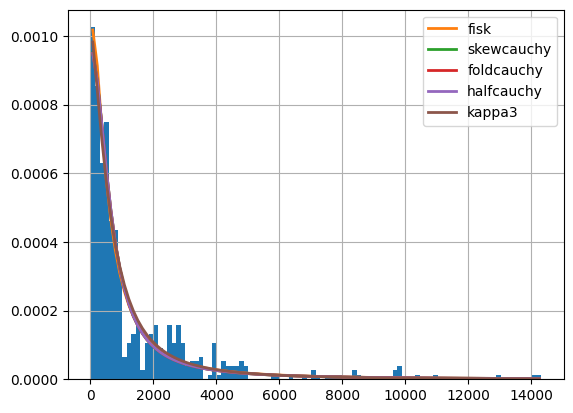

In [ ]:
fa.summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gibrat,2.545792e-07,1973.174885,-12642.194398,inf,0.061746,0.021795
gilbrat,2.545792e-07,1973.174885,-12642.194398,inf,0.061746,0.021795
norminvgauss,2.574320e-07,1974.248328,-12622.903079,inf,0.067107,0.009640
wald,2.575419e-07,1970.360133,-12635.402543,inf,0.067352,0.009272
johnsonsu,2.601867e-07,1977.712651,-12616.655040,inf,0.065589,0.012229


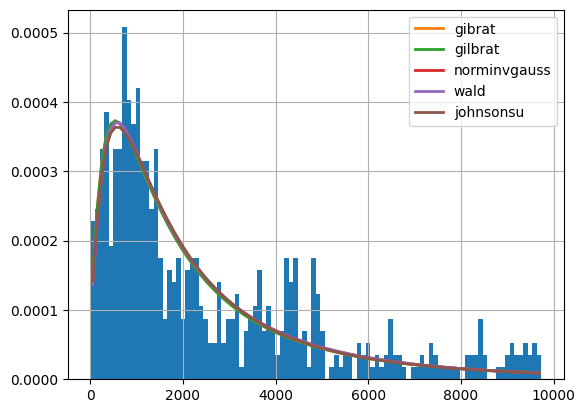

In [ ]:
fb.summary()

Create gibrat distribution

In [ ]:
r = gibrat.rvs(loc=4, scale=12, size=1000)
r_int = [round(x) for x in r]
gibrat_values = []
for num in r_int:
    if num < 50:
        gibrat_values.append(num)

<BarContainer object of 50 artists>

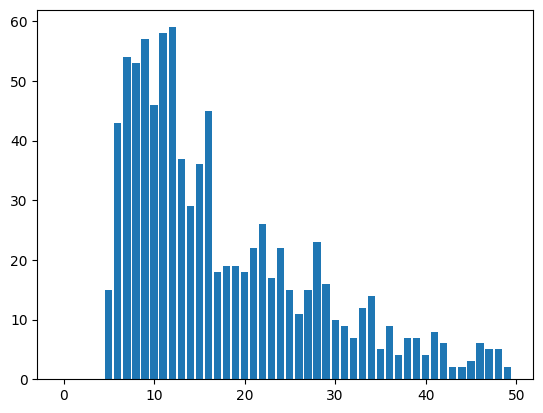

In [ ]:
size = max(gibrat_values)
x_axis = [x for x in range(size+1)]
y_axis = np.zeros(size+1)

for num in gibrat_values:
    y_axis[num] += 1

plt.bar(x_axis, y_axis)

## Generate user data

### using gibrat distribution

In [ ]:
names = []
albums = []
user_money = []

with open('gdrive/My Drive/HUA/6th Semester/Decision Making Systems/Semester Project/new-top-firstNames.csv') as names_csv:
    csv_reader = csv.reader(names_csv, delimiter=',')
    headers = next(csv_reader)
    names = list(csv_reader)

with open('gdrive/My Drive/HUA/6th Semester/Decision Making Systems/Semester Project/albumlist_reduced.csv', encoding = "ISO-8859-1") as albums_csv:
    csv_reader = csv.reader(albums_csv, delimiter=',')
    headers = next(csv_reader)
    albums = list(csv_reader)

with open('gdrive/My Drive/HUA/6th Semester/Decision Making Systems/Semester Project/user_money_rates.csv') as user_money_rates:
    csv_reader = csv.reader(user_money_rates, delimiter=',')
    headers = next(csv_reader)
    user_money = list(csv_reader)

user_data = []
# for each user
for i in range(1, community_graph.number_of_nodes()+1):
    available_albums = [x for x in albums]
    available_artists = [x[3] for x in albums]

    #name select
    selected_name = random.choice(names)
    name = selected_name[1]
    names.remove(selected_name)

    #available money
    user_money_rate = random.choice(user_money)
    money = float(user_money_rate[0])

    #Favourite artists
    favourite_artists = []
    for j in range(random.choice(gibrat_values)):
        if len(available_artists) == 0:
            break
        choice = random.choice(available_artists)
        favourite_artists.append(choice)
        available_artists.remove(choice)


    #Owned albums
    owned_albums = []
    for j in range(random.choice(gibrat_values)):
        if len(available_albums) == 0:
            break
        choice = random.choice(available_albums)
        owned_albums.append({"album":choice[2], "artist":choice[3]})
        available_albums.remove(choice)


    #Album interests
    album_interests = []
    user_money_idx = 1
    for c in range(random.choice(gibrat_values)):
        if len(available_albums) == 0:
            break
        choice = random.choice(available_albums)
        album_interests.append({"album":choice[2], "artist":choice[3], "interest_coeff":int(float(user_money_rate[user_money_idx]))}) #LOL
        user_money_idx += 1
        if user_money_idx > len(user_money):
            user_money_idx = 1

    friends = [x for x in community_graph.neighbors(i)]

    user_data.append({
        "username":name,
        "money":money,
        "friends":friends,
        "favourite_artists":favourite_artists,
        "owned_albums":owned_albums,
        "album_interests":album_interests
    })

    # with open('gdrive/My Drive/HUA/6th Semester/Decision Making Systems/Semester Project/20_user_data_gibrat.json', 'w') as json_file:
    #      json.dump(user_data, json_file, sort_keys = True, indent = 4)

# β. API and DB inserts

(β.) Για τον κάθε user του community φτιαξτε συναρτήσεις που να ανακτούν δεδομένα από τα opendata σε σχέση με τα συγκροτήματα που ακούει και τους δίσκους που τον ενδιαφέρουν και να γεμίζουν τα αντίστοιχα tables στην ΒΔ. [Rest calls στα [1] [2] και Διάλεξη 3 MySQL]

Σημείωση: Για την επιλογή των attributes λάβετε υπόψη σας τα επόμενα ερωτήματα. Είναι φυσικό καθώς εξοικειώνεστε με την εργασία να αλλάζετε το σχήμα της ΒΔ και τα attributes).

[1] https://www.last.fm/api

[2] https://www.discogs.com/developers

## Setup API functions

In [ ]:
#last.fm

BASE_URL ='https://ws.audioscrobbler.com'
API_KEY = 'dcd11816eb4ea6a7e2f20e4cffb34bd5'

def API_artist_info(artist_name: str):
    """Retrieve information about an artist from the last.fm API.

    :param artist_name: The name of the artist, required.
    :return: A JSON formatted string.
    """
    time.sleep(0.1)
    response = requests.get(f'{BASE_URL}/2.0/?method=artist.getinfo&artist={artist_name}&api_key={API_KEY}&format=json')
    return json.loads(response.content)
    # formatted = json.dumps(json.loads(response.content), indent=2)
    # return formatted

def API_album_info(artist_name: str, album_name: str):
    """Retrieve information about an album from the last.fm API.

    :param artist_name: The name of the artist, required.
    :param album_name: The name of the album, required.
    :return: A JSON formatted string.
    """
    time.sleep(0.1)
    response = requests.get(f'{BASE_URL}/2.0/?method=album.getinfo&api_key={API_KEY}&artist={artist_name}&album={album_name}&format=json')
    return json.loads(response.content)
    # formatted = json.dumps(json.loads(response.content), indent=2)
    # return formatted

def API_album_search(album_name: str):
    """Search for an album by name from the last.fm API.
    Returns album matches sorted by relevance.

    :param album_name: The name of the album, required.
    :return: A JSON formatted string.
    """
    time.sleep(0.1)
    response = requests.get(f'{BASE_URL}/2.0/?method=album.search&album={album_name}&api_key={API_KEY}&format=json')
    return json.loads(response.content)
    #   formatted = json.dumps(json.loads(response.content), indent=2)
    #   return formatted

## Insert data process functions

In [ ]:
def make_price_history():
    series = pd.read_csv('gdrive/My Drive/HUA/6th Semester/Decision Making Systems/Semester Project/File_series.csv', header=0, parse_dates=[0])
    series.columns = ['date','price']
    series_list = list(series['price'])
    index = random.randint(0, len(series_list))
    spliced1 = series_list[index:len(series_list)]
    spliced2 = series_list[0:index]
    new_time_series = spliced1 + spliced2
    series['price'] = new_time_series
    return series

In [ ]:
#IMPORTANT artists with an & in the name are not inserted into the DB from the & and after.

def insert_artist_process(artist_name: str)-> int:
    """Insert artist info into DB and return the artist's id.
    If no artist with that name already exists in the DB call API and retrieve the artist's data.
    If the artist exists in the DB return the artist's id.

    :param artist_name: The name of the artist, required.
    :return: An integer of the artist id
    """

    #retrieve artists from DB
    info_from_db = DB_find_artist(artist_name)

    #if artist info from db is empty get info from API
    if info_from_db is not None:
        return info_from_db
    else:
        #call API
        # info_from_api = json.loads(API_artist_info(artist_name))
        info_from_api = API_artist_info(artist_name)

        artist_obj = {'name':artist_name, 'genre':'NULL'}

        # check if json fields are valid
        if 'artist' in info_from_api and 'name' in info_from_api['artist']:
            artist_obj['name'] = info_from_api['artist']['name']

        if 'artist' in info_from_api and 'tags' in info_from_api['artist'] and 'tag' in info_from_api['artist']['tags'] and isinstance(info_from_api['artist']['tags']['tag'], list) and info_from_api['artist']['tags']['tag'] and 'name' in info_from_api['artist']['tags']['tag'][0]:
            artist_obj['genre'] = info_from_api['artist']['tags']['tag'][0]['name']

        # insert artist into DB with valid info or NULL values
        artist_id = DB_insert_artist(artist_obj['name'], artist_obj['genre'])

        return artist_id

In [ ]:
def insert_album_process(album_name: str, artist_name: str, artist_id: int, price: float)-> int:
    """Insert artist info into DB and return the artist's id.
    If no artist with that name already exists in the DB call API and retrieve the artist's data.
    If the artist exists in the DB return the artist's id.

    :param album_name: The name of the album, required.
    :param artist_name: The name of the artist, required.
    :param artist_id: The id of the artist from the DB, required.
    :return: An integer of the album id
    """

    #Retrieve artists from DB
    info_from_db = DB_find_album(album_name)

    #If artist info from db is empty get info from API
    if info_from_db is not None:
        return info_from_db
    else:
        #Call API
        # info_from_api = json.loads(API_album_info(artist_name, album_name))
        info_from_api = API_album_info(artist_name, album_name)

        album_obj = {'name':'NULL', 'artist':artist_id, 'price':0}

        #Insert artist into DB with valid info or NULL values
        if 'album' in info_from_api and 'name' in info_from_api['album']:
            album_obj['name'] = info_from_api['album']['name']

        album_id = DB_insert_album(album_obj['name'], artist_id, price)

        #insert price history for album
        price_history_series = make_price_history()
        DB_insert_price_history(album_id, price_history_series) #randomize start of prices


        #Insert album tracks into the DB
        if 'album' in info_from_api and 'tracks' in info_from_api['album'] and 'track' in info_from_api['album']['tracks'] and info_from_api['album']['tracks']['track']:

            song_list = []
            if isinstance(info_from_api['album']['tracks']['track'], list):
                for track in info_from_api['album']['tracks']['track']:
                    song_list.append({'name':track['name'], 'duration':track['duration']})
            else:
                song_list.append({'name':info_from_api['album']['tracks']['track']['name'], 'duration':info_from_api['album']['tracks']['track']['duration']})

            DB_insert_tracks(song_list, album_id)

    return album_id

In [ ]:
def insert_into_db(data: str):
    """Parse JSON file that contains user data and fill the DB with the info.

    :param data: A JSON formated string containing user data. Required.
    """
    album_prices = []
    with open('gdrive/My Drive/HUA/6th Semester/Decision Making Systems/Semester Project/album_price.csv') as album_prices:
        csv_reader = csv.reader(album_prices, delimiter=',')
        headers = next(csv_reader)
        album_prices = list(csv_reader)

    users = []

    for user in data:

        user_id = DB_find_user(user['username'])

        if user_id is None:
            user_id = DB_insert_user(user['username'], user['money'])

        for artist in user['favourite_artists']:

            #insert artist into DB
            artist_id = insert_artist_process(artist)
            #make connection to secondary table
            DB_insert_favourite_artists(user_id, artist_id)

        # for artists in owned albums
        for album in user['owned_albums']:

            #insert artist into DB
            artist_id = insert_artist_process(album['artist'])

            #insert album into DB
            album_id = insert_album_process(album['album'], album['artist'], artist_id, float(random.choice(album_prices)[0]))
            #make connection to secondary table for user and album
            DB_insert_owned_albums(user_id, album_id)

        # for artists in owned albums
        for album in user['album_interests']:

            #insert artist into DB
            artist_id = insert_artist_process(album['artist'])

            #insert album into DB
            album_id = insert_album_process(album['album'], album['artist'], artist_id, float(random.choice(album_prices)[0]))
            #make connection to secondary table for user and album
            DB_insert_album_interests(user_id, album_id, album['interest_coeff'])

        users.append({'id':user_id, 'friends':user['friends']})

    # Insert friends
    for user in users:
        DB_insert_friends(user['id'], user['friends'])

## **Make the DB inserts

In [ ]:
# DB_drop_tables()
# DB_create_tables()

In [ ]:
with open('gdrive/My Drive/HUA/6th Semester/Decision Making Systems/Semester Project/20_user_data_gibrat.json') as user_data_json:
    data = json.load(user_data_json)

insert_into_db(data)

User Richard with ID: 1 got inserted!
Artist Led Zeppelin with ID: 1 got inserted!
User's 1 favorite_artists with ID: 1 got inserted!
Artist Santana with ID: 2 got inserted!
User's 1 favorite_artists with ID: 2 got inserted!
Artist Dr. John, the Night Tripper with ID: 3 got inserted!
User's 1 favorite_artists with ID: 3 got inserted!
Artist Funkadelic with ID: 4 got inserted!
User's 1 favorite_artists with ID: 4 got inserted!
Artist Neil Young with ID: 5 got inserted!
User's 1 favorite_artists with ID: 5 got inserted!
Artist The Clash with ID: 6 got inserted!
User's 1 favorite_artists with ID: 6 got inserted!
Artist Bruce Springsteen with ID: 7 got inserted!
User's 1 favorite_artists with ID: 7 got inserted!
Artist The Byrds with ID: 8 got inserted!
User's 1 favorite_artists with ID: 8 got inserted!
Artist Buddy Holly with ID: 9 got inserted!
User's 1 favorite_artists with ID: 9 got inserted!
Artist Elvis Costello with ID: 10 got inserted!
User's 1 favorite_artists with ID: 10 got inse

# γ. DB Cleanup

(γ.) Υλοποιήστε μια συνάρτηση που να κάνει έλεγχο και να αντιμετωπίζει [missing](https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b) [4], [duplicate](https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python) [5] ή [outlier](https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623) [6] values σε κάποιο από τα attributes της ΒΔ.

[4] https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b

[5] https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python

[6] https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623

## Fill DB with junk data

### Fill DB with junk

In [ ]:
junk_values = ['N/A', 'NA', 'n/a', 'na', '--', 'null', 'NULL', 'invalid', '']

percentage = 0.05

artists = DB_select_all_artists()
users = DB_select_all_users()
albums = DB_select_all_albums()

for i in range(0, math.ceil(len(users) * percentage)):
    DB_update_user_name(random.choice(users)[0], random.choice(junk_values))

for i in range(0, math.ceil(len(artists) * percentage)):
    DB_update_artist_name(random.choice(artists)[0], random.choice(junk_values))

for i in range(0, math.ceil(len(albums) * percentage)):
    DB_update_album_name(random.choice(albums)[0], random.choice(junk_values))

### DB prints before cleanup

In [ ]:
pd_users = pd.DataFrame(DB_select_all_users(),  columns=['id','name','funds'])
pd_users

,id,name,funds
0,1,Richard,216.0
1,2,Thomas,251.0
2,3,Christine,253.0
3,4,Matthew,248.0
4,5,Emily,297.0
5,6,John,232.0
6,7,Jose,207.0
7,8,Samuel,205.0
8,9,Stephanie,227.0
9,10,Tyler,281.0


In [ ]:
pd_artists = pd.DataFrame(DB_select_all_artists(), columns=['id','name','genre'])
pd_artists

,id,name,genre
0,1,Led Zeppelin,classic rock
1,2,Santana,rock
2,3,"Dr. John, the Night Tripper",Psychedelic Rock
3,4,Funkadelic,funk
4,5,Neil Young,classic rock
...,...,...,...
149,150,Sam Cooke,soul
150,151,Pretenders,rock
151,152,Cat Stevens,folk
152,153,ABBA,pop


In [ ]:
pd_albums = pd.DataFrame(DB_select_all_albums(),  columns=['id','name','artist_id','price'])
pd_albums

,id,name,artist_id,price
0,1,Doolittle,33,29.0
1,2,Blonde on Blonde,30,40.0
2,3,Purple Rain,34,16.0
3,4,Sticky Fingers,35,2.0
4,5,Younger Than Yesterday,8,18.0
...,...,...,...,...
250,251,Otis Blue: Otis Redding Sings Soul,98,8.0
251,252,NULL,100,18.0
252,253,20 Golden Greats,9,34.0
253,254,NULL,59,27.0


## Cleanup DB from junk data

### Utility functions

In [ ]:
def find_artist_from_album(album_name):
    response = API_album_search(album_name)
    artist = None
    if 'results' in response:
        if 'albummatches' in response['results']:
            if 'album' in response['results']['albummatches']:
                if isinstance(response['results']['albummatches']['album'], list):
                    return response['results']['albummatches']['album'][0]['artist']
                else:
                    return response['results']['albummatches']['album']['artist']
    return artist

In [ ]:
def find_ids_with_invalid_values(df):
    """Finds and returns ids from database tuples that contain invalid data.

    :param data, a DB select of items
    :return: An array of integers corresponding to the ids in the DB table.
    """
    missing_values = ['N/A', 'NA', 'n/a', 'na', '--', 'null', 'NULL', 'invalid', '']
    filtered = df[np.isin(df, missing_values).any(axis=1)]
    ids = filtered.iloc[:, 0].values
    return ids, filtered

### Cleanup

Find invalid values in albums

In [ ]:
df = pd.DataFrame(data = DB_select_all_albums(), columns=['id','name','artist id','price'])
ids, values = find_ids_with_invalid_values(df)
print(values)

      id     name  artist id  price
5      6      n/a         36    2.0
54    55     NULL         73   48.0
61    62     NULL         73   20.0
65    66       --         38   47.0
83    84      n/a         95   38.0
86    87      N/A         96   47.0
90    91     NULL        100   12.0
95    96       na        101    7.0
104  105     NULL        100    2.0
105  106     NULL         73    8.0
115  116     NULL         80   45.0
130  131      N/A          5   21.0
134  135      N/A        125    7.0
140  141       NA          7   48.0
147  148     NULL         81   16.0
155  156     NULL        100   17.0
175  176      n/a        135   28.0
177  178       NA         97   13.0
184  185     NULL        100   18.0
185  186     NULL         80   29.0
204  205     NULL         80   45.0
206  207     NULL         73   26.0
218  219     NULL         73   26.0
221  222  invalid         22   25.0
222  223     NULL         73   21.0
225  226     NULL        100    9.0
232  233     NULL        100

Cleanup albums

In [ ]:
print('Cleaning invalid values in albums...')
DB_delete_album_interests(ids)
DB_delete_album_owners(ids)
for id in ids:
    tracks = DB_select_tracks_from_album(id)
    if tracks:
        track_ids = [x[0] for x in tracks]
        DB_delete_tracks(track_ids)

DB_delete_price_history(ids)
DB_delete_albums(ids)
print('Done')

Cleaning invalid values in albums...
Done


Find invalid values for artists

In [ ]:
df = pd.DataFrame(data = DB_select_all_artists(), columns=['id','name','genre'])
ids, values = find_ids_with_invalid_values(df)
print(values)

      id                            name              genre
35    36                             n/a             Grunge
55    56                                       classic rock
64    65                             N/A           shoegaze
80    81                      The B 52's               NULL
85    86                            NULL               funk
91    92                              na       classic rock
97    98                              --               soul
99   100                             N/A      Rock and Roll
107  108  John Lennon / Plastic Ono Band               NULL
146  147                             n/a  singer-songwriter


Cleanup artists

In [ ]:
print('Cleaning invalid values in artists...')
#update artist name where possible
for id in ids:
    albums = DB_find_albums_belonging_to_artist(id)
    if albums:
        for album in albums:
            artist = find_artist_from_album(album[1]) #artist name
            if artist:
                DB_update_artist_name(id, artist)
                # ids.remove(id)
                ids = np.delete(ids, np.where(ids == id))
                break
#for the rest
for id in ids:
    DB_update_artist_name(id, 'Unknown artist')
print('Done')

Cleaning invalid values in artists...
Done


Find Invalid values for users

In [ ]:
df = pd.DataFrame(data = DB_select_all_users(), columns=['id','name','money'])
ids, values = find_ids_with_invalid_values(df)
print(values)

    id  name  money
14  15  NULL  282.0


Cleanup users

In [ ]:
print('Cleaning invalid values in users...')
user = 1
for id in ids:
    DB_update_user_name(id, 'User ' + str(user))
    user += 1
print('Done')

Cleaning invalid values in users...
Done


### DB prints after cleanup

In [ ]:
pd_users = pd.DataFrame(DB_select_all_users(),  columns=['id','name','funds'])
pd_users

,id,name,funds
0,1,Richard,216.0
1,2,Thomas,251.0
2,3,Christine,253.0
3,4,Matthew,248.0
4,5,Emily,297.0
5,6,John,232.0
6,7,Jose,207.0
7,8,Samuel,205.0
8,9,Stephanie,227.0
9,10,Tyler,281.0


In [ ]:
pd_artists = pd.DataFrame(DB_select_all_artists(), columns=['id','name','genre'])
pd_artists

,id,name,genre
0,1,Led Zeppelin,classic rock
1,2,Santana,rock
2,3,"Dr. John, the Night Tripper",Psychedelic Rock
3,4,Funkadelic,funk
4,5,Neil Young,classic rock
...,...,...,...
149,150,Sam Cooke,soul
150,151,Pretenders,rock
151,152,Cat Stevens,folk
152,153,ABBA,pop


In [ ]:
pd_albums = pd.DataFrame(DB_select_all_albums(),  columns=['id','name','artist_id','price'])
pd_albums

,id,name,artist_id,price
0,1,Doolittle,33,29.0
1,2,Blonde on Blonde,30,40.0
2,3,Purple Rain,34,16.0
3,4,Sticky Fingers,35,2.0
4,5,Younger Than Yesterday,8,18.0
...,...,...,...,...
218,248,Rumours,29,37.0
219,250,Nuggets: Original Artyfacts from the First Psy...,78,46.0
220,251,Otis Blue: Otis Redding Sings Soul,98,8.0
221,253,20 Golden Greats,9,34.0


## Create dublicates in DB

In [ ]:
percentage = 0.05

artists = DB_select_all_artists()
users = DB_select_all_users()
albums = DB_select_all_albums()

for i in range(0, math.ceil(len(artists) * percentage)):
    artist = random.choice(artists)
    DB_insert_artist(artist[1], artist[2])

for i in range(0, math.ceil(len(albums) * percentage)):
    album = random.choice(albums)
    DB_insert_album(album[1], album[2], album[3])

for i in range(0, math.ceil(len(users) * percentage)):
    user = random.choice(users)
    DB_insert_user(user[1], user[2])

Artist The Clash with ID: 171 got inserted!
Artist The Replacements with ID: 172 got inserted!
Artist Linda Ronstadt with ID: 173 got inserted!
Artist The Replacements with ID: 174 got inserted!
Artist Janis Joplin with ID: 175 got inserted!
Artist Linda Ronstadt with ID: 176 got inserted!
Artist Michael Jackson with ID: 177 got inserted!
Artist Radiohead with ID: 178 got inserted!
Album Otis Blue: Otis Redding Sings Soul with ID: 280 got inserted!
Album Live At The Apollo 1962 with ID: 281 got inserted!
Album Close To You with ID: 282 got inserted!
Album Bridge Over Troubled Water with ID: 283 got inserted!
Album Tim with ID: 284 got inserted!
Album In the Wee Small Hours with ID: 285 got inserted!
Album Desire with ID: 286 got inserted!
Album Live At The Regal with ID: 287 got inserted!
Album Nuggets: Original Artyfacts from the First Psychedelic Era, 1965-1968 with ID: 288 got inserted!
Album The Wall with ID: 289 got inserted!
Album London Calling with ID: 290 got inserted!
Album T

### Print DB dublicated entries

Artists

In [ ]:
df = pd.DataFrame(data = DB_select_all_artists(), columns=['id','name','genre'])
dubs = df[df[['name']].duplicated()]
dubs

,id,name,genre
153,171,The Clash,punk
154,172,The Replacements,alternative
155,173,Linda Ronstadt,female vocalists
156,174,The Replacements,alternative
157,175,Janis Joplin,classic rock
158,176,Linda Ronstadt,female vocalists
159,177,Michael Jackson,pop
160,178,Radiohead,alternative


Albums

In [ ]:
df = pd.DataFrame(data = DB_select_all_albums(), columns=['id','name','artist_id','price'])
dubs = df[df[['name']].duplicated()]
dubs

,id,name,artist_id,price
221,280,Otis Blue: Otis Redding Sings Soul,98,7.0
222,281,Live At The Apollo 1962,87,7.0
223,282,Close To You,72,43.0
224,283,Bridge Over Troubled Water,39,21.0
225,284,Tim,17,47.0
226,285,In the Wee Small Hours,16,2.0
227,286,Desire,30,12.0
228,287,Live At The Regal,96,9.0
229,288,Nuggets: Original Artyfacts from the First Psy...,78,28.0
230,289,The Wall,45,7.0


Users

In [ ]:
df = pd.DataFrame(data = DB_select_all_users(), columns=['id','name','money'])
dubs = df[df[['name']].duplicated()]
dubs

,id,name,money
20,23,Emily,297.0


## Cleanup DB from dublicates

In [ ]:
def find_dublicate_ids(df):
    # Return only the extra values
    extra = df[df[['name']].duplicated()]
    ids = extra.iloc[:, 0].values
    return ids, extra

In [ ]:
df = pd.DataFrame(data = DB_select_all_artists(), columns=['id','name','genre'])
ids, data = find_dublicate_ids(df)
print(data)
if ids.size > 0:
    DB_delete_artists(ids)

df = pd.DataFrame(data = DB_select_all_albums(), columns=['id','name','artist_id','price'])
ids, data = find_dublicate_ids(df)
print(data)
if ids.size > 0:
    DB_delete_albums(ids)

df = pd.DataFrame(data = DB_select_all_users(), columns=['id','name','money'])
ids, data = find_dublicate_ids(df)
print(data)
if ids.size > 0:
    DB_delete_users(ids)

      id              name             genre
153  171         The Clash              punk
154  172  The Replacements       alternative
155  173    Linda Ronstadt  female vocalists
156  174  The Replacements       alternative
157  175      Janis Joplin      classic rock
158  176    Linda Ronstadt  female vocalists
159  177   Michael Jackson               pop
160  178         Radiohead       alternative
      id                                               name  artist_id  price
221  280                 Otis Blue: Otis Redding Sings Soul         98    7.0
222  281                            Live At The Apollo 1962         87    7.0
223  282                                       Close To You         72   43.0
224  283                         Bridge Over Troubled Water         39   21.0
225  284                                                Tim         17   47.0
226  285                             In the Wee Small Hours         16    2.0
227  286                                         

### Print dublicates after removeal (should print nothing)

Artists

In [ ]:
df = pd.DataFrame(data = DB_select_all_artists(), columns=['id','name','genre'])
dubs = df[df[['name']].duplicated()]
dubs

,id,name,genre


Albums

In [ ]:
df = pd.DataFrame(data = DB_select_all_albums(), columns=['id','name','artist_id','price'])
dubs = df[df[['name']].duplicated()]
dubs

,id,name,artist_id,price


Users

In [ ]:
df = pd.DataFrame(data = DB_select_all_users(), columns=['id','name','money'])
dubs = df[df[['name']].duplicated()]
dubs

,id,name,money


## Create outliers in DB data

Calculate standard deviation and mean value for normal price ranges

In [ ]:
albums = DB_select_all_albums()
data = [x[3] for x in albums]
mean = round(np.mean(data), 2)

random_data_std = np.std(data)
random_data_mean = np.mean(data)
anomaly_cut_off = random_data_std * 3

lower_limit  = random_data_mean - anomaly_cut_off
upper_limit = random_data_mean + anomaly_cut_off

print("Lower limit =",lower_limit)
print("Upper limit =",upper_limit)
print("Mean = ", mean)

Lower limit = -16.504115446733287
Upper limit = 67.31859508474233
Mean =  25.41


Print albums

In [ ]:
df_albums = pd.DataFrame(data = DB_select_all_albums(), columns=['id','name','artist_id','price'])
df_albums

Alter prices with random values

In [ ]:
percentage = 0.1
for i in range(0, math.ceil(len(albums) * percentage)):
    neg_value = random.uniform(-10000, -100)
    pos_value = random.uniform(100, 10000)
    DB_update_album_price(random.choice(albums)[0], random.choice([neg_value, pos_value]))

## Cleanup outliers

Detect outliers

In [ ]:
albums = DB_select_all_albums()
data = [[x[0], x[3]] for x in albums]

anomalies = []
for outlier in data:
    if outlier[1] > upper_limit or outlier[1] < lower_limit:
        anomalies.append(outlier)
print(anomalies)

Print anomalous values (album_id, value)

In [ ]:
anomalies

[[6, 6221.436905264967],
 [21, -576.2067102620586],
 [34, 2264.0790805572715],
 [36, -5829.7989408902495],
 [45, 2204.5328097376596],
 [56, -172.71206160237125],
 [65, -7321.630718583876],
 [82, 2541.7486733253318],
 [84, -7289.844164275841],
 [89, -7658.758944424144],
 [99, 8330.68619949197],
 [107, 8033.495171187],
 [132, -6744.851299840142],
 [147, -1637.7929389857509],
 [149, 9665.725946529168],
 [151, 7789.708983119536],
 [171, 1819.832983402265],
 [174, -4015.9499692593517],
 [175, 1574.0815986684966],
 [182, 4589.958876734604],
 [216, -4154.380017039364],
 [227, -6514.383912828267],
 [232, -5474.9259959758165]]

Deal with outliers by using average price

In [ ]:
for album in anomalies:
    DB_update_album_price(album[0], mean)

Print DB albums after dealing with outliers (using average price)

In [ ]:
df_albums = pd.DataFrame(data = DB_select_all_albums(), columns=['id','name','artist_id','price'])
df_albums

,id,name,artist_id,price
0,1,Doolittle,33,40.0
1,2,Blonde on Blonde,30,26.0
2,3,Purple Rain,34,32.0
3,4,Sticky Fingers,35,7.0
4,5,Younger Than Yesterday,8,34.0
...,...,...,...,...
216,248,Rumours,29,7.0
217,250,Nuggets: Original Artyfacts from the First Psy...,78,28.0
218,251,Otis Blue: Otis Redding Sings Soul,98,7.0
219,253,20 Golden Greats,9,37.0


# δ. Statistics

(δ.) Βγάλτε κάποια στατιστικά συμπεράσματα για τα data features [7] [8]

[7] https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html

[8] https://sparkbyexamples.com/pandas/calculate-summary-statistics-in-pandas/

## Load data into dataframes

In [ ]:
# Load data into pandas DataFrames
users = pd.DataFrame(DB_select_all_users(), columns=['id', 'username', 'money'])
artists = pd.DataFrame(DB_select_all_artists(), columns=['id', 'name', 'genre'])
albums = pd.DataFrame(DB_select_all_albums(), columns=['id', 'name', 'artist_id', 'price'])
tracks = pd.DataFrame(DB_select_all_tracks(), columns=['id', 'album_id', 'track_name', 'duration'])

### Data filters

In [ ]:
# print(f"In the beginning, there were {len(artists)} artists, and {len(albums)} albums in DB.")

# # For artists
# artist_ids_torem = []

# for sym in ['', 'N/A', '--', 'null']:
#     artist_ids_torem.append(artists[artists['name'] == sym]['id'].iloc[0])
#     artists = artists[artists['name'] != sym]

# print(f'Removed artist ids {artist_ids_torem}.')

# # For albums
# albums = albums[(albums['price'] >= 1) & (albums['price'] <= 50)]   # To remove the outliers in album prices

# album_ids_torem = albums[albums['artist_id'].isin(artist_ids_torem)]['id'].values

# print(f'List of album ids to be removed because of the removed artists: {album_ids_torem}.')
# albums = albums[~albums['artist_id'].isin(artist_ids_torem)]

# print(f'After removing {len(artist_ids_torem)} artists and {len(album_ids_torem)} albums, there are {len(artists)} artists and {len(albums)} albums.\n')

# # For album_interests
# # Join album interests with albums and artists DataFrames using appropriate keys
# album_interests_list = []
# for id in users["id"]:
#     entry = pd.DataFrame(DB_select_user_album_interests(id), columns=['album_id', 'album_name', 'artist_name', 'album_price', 'interest_coeff'])
#     entry = entry[~entry['album_id'].isin(album_ids_torem)]
#     entry = entry[(entry['album_price'] >= 1) & (entry['album_price'] <= 50)]
#     album_interests_list.append(entry)

##Users statistical analysis

In [ ]:
users

In [ ]:
# Descriptive Statistics
print(f'There are {len(users)} users in DB.\n')
# Calculate the max, min, mean, median, and standard deviation of the users' money
user_money_max = users['money'].max()
user_money_min = users['money'].min()
user_money_mean = users['money'].mean()
user_money_median = users['money'].median()
user_money_std = users['money'].std()

print(f"Users' descriptive statistics \nmoney max: \t{user_money_max} \
\nmoney min: \t{user_money_min} \nmoney mean: \t{user_money_mean.round(2)} \
\nmoney median: \t{user_money_median} \nmoney std: \t{user_money_std.round(2)}")

There are 20 users in DB.

Users' descriptive statistics 
money max: 	297.0 
money min: 	205.0 
money mean: 	249.05 
money median: 	249.5 
money std: 	30.45


## Artists statistical analysis

In [ ]:
print(f'There are {len(artists)} artists in DB.')

There are 153 artists in DB.


In [ ]:
# Group albums by artist and calculate the average price for each artist
avg_price_by_artist = albums.groupby('artist_id')['price'].mean().sort_values(ascending=False)
top_artists_index = avg_price_by_artist.head().index
artist_names = artists[artists['id'].isin(top_artists_index)]['name'].values

print(f'Top 5 most expensive artists\n')
for i, name in enumerate(artist_names):
    print(f'{i+1}. {name}')

Top 5 most expensive artists

1. Santana
2. Funkadelic
3. Public Enemy
4. Curtis Mayfield
5. Television


In [ ]:
# Group albums by artist and count the number of albums for each artist
artist_album_counts = albums.groupby('artist_id')['name'].count()

# Sort the artists based on album counts in descending order
top_artists = artist_album_counts.sort_values(ascending=False).head(15)

# Get the artist names using artist_id from the artists DataFrame
top_artists_names = artists.loc[top_artists.index, 'name']

# Display the top 5 most famous artists by the number of their albums
top_artists_data = pd.DataFrame({'Artist Name': top_artists_names, 'Album Count': top_artists})
display(top_artists_data)

,Artist Name,Album Count
artist_id,,
35,Pearl Jam,8
30,Stevie Wonder,6
22,Guns N' Roses,6
1,Santana,5
38,Simon And Garfunkel,5
7,The Byrds,5
112,Hank Williams,3
39,Radiohead,3
45,Beastie Boys,3


## Albums statistical analysis

In [ ]:
# Find the minimum and maximum prices of albums and their artist
album_min_price = albums['price'].min()
cheapest_album = albums[albums['price'] == album_min_price]['name'].values[0]
cheapest_album_id = albums[albums['price'] == album_min_price]['id'].values[0]
cheapest_album_artist_id = albums[albums['price'] == album_min_price]['artist_id'].values[0]
cheapest_album_artist = artists[artists['id'] == cheapest_album_artist_id]['name'].values[0]

album_max_price = albums['price'].max()
most_expensive_album = albums[albums['price'] == album_max_price]['name'].values[0]
most_expensive_album_id = albums[albums['price'] == album_max_price]['id'].values[0]
most_expensive_album_artist_id = albums[albums['price'] == album_max_price]['artist_id'].values[0]
most_expensive_album_artist = artists[artists['id'] == most_expensive_album_artist_id]['name'].values[0]


print(f"Biggest price is ${album_max_price}, for '{most_expensive_album}' (album_id: {most_expensive_album_id}) \
album by '{most_expensive_album_artist}' (artist_id: {most_expensive_album_artist_id}), \
and\nsmallest price is ${album_min_price} for '{cheapest_album}' (album_id: {cheapest_album_id}) album by '{cheapest_album_artist}' \
(artist_id: {cheapest_album_artist_id}).")

Biggest price is $49.0, for 'Santana' (album_id: 57) album by 'Santana' (artist_id: 2), and
smallest price is $2.0 for 'The Stranger' (album_id: 63) album by 'Billy Joel' (artist_id: 77).


In [ ]:
# Total albums' tracks' duration
album_durations = tracks.groupby('album_id')['duration'].sum()
top_albums = album_durations.nlargest(5)

top_albums = top_albums.reset_index()  # Reset index to access 'album_id' as a column
top_albums = top_albums.merge(albums[['id', 'name']], left_on='album_id', right_on='id')
top_albums = top_albums[['name', 'duration']]  # Select only the 'name' and 'duration' columns
top_albums.columns = ['Album Name', 'Total Duration (sec)']  # Rename the columns
top_albums.index += 1
top_albums

,Album Name,Total Duration (sec)
1,Star Time,12649.0
2,Back to Mono (1958-1969),9193.0
3,The Definitive Collection,8950.0
4,Mr. Excitement!,8563.0
5,The Birth Of Soul,8540.0


In [ ]:
# Merged artists and albums. In alphabetical order using artist names.
album_artist_merge = pd.merge(albums, artists, left_on='artist_id', right_on='id').sort_values(by='name_y').reset_index()
album_artist_merge = album_artist_merge[['name_y', 'genre', 'name_x', 'price']]
album_artist_merge.columns = ['Artist name', 'Genre', 'Album name', 'Album price']
album_artist_merge.index += 1
album_artist_merge

,Artist name,Genre,Album name,Album price
1,A Tribe Called Quest,Hip-Hop,The Low End Theory,16.0
2,ABBA,pop,The Definitive Collection,20.0
3,AC/DC,hard rock,Highway to Hell,9.0
4,AC/DC,hard rock,Back in Black,7.0
5,Aerosmith,rock,Rocks,8.0
...,...,...,...,...
217,Van Morrison,classic rock,Moondance,36.0
218,Various Artists,electronic,Nuggets: Original Artyfacts from the First Psy...,28.0
219,Various Artists,electronic,Saturday Night Fever: The Original Movie Sound...,33.0
220,Various Artists,electronic,The Harder They Come,20.0


In [ ]:
album_interests_list = []
for id in users["id"]:
    entry = pd.DataFrame(DB_select_user_album_interests(id), columns=['album_id', 'album_name', 'artist_name', 'album_price', 'interest_coeff'])
    album_interests_list.append(entry)

owned_albums_list = []
for id in users["id"]:
    entry = pd.DataFrame(DB_select_user_owned_albums(id), columns=['album_id', 'album_name', 'artist_name'])
    owned_albums_list.append(entry)

In [ ]:
# Every album interest of each user (in table form)
for i, id in enumerate(users["id"]):
    print(f"\t\t{users['username'][i]}'s album interests (user_id: {id})")
    display(album_interests_list[i])
    print('\n')

		Richard's album interests (user_id: 1)


,album_id,album_name,artist_name,album_price,interest_coeff
0,18,Loaded,The Velvet Underground,32.00,4
1,19,Black Sabbath,Black Sabbath,43.00,3
2,21,Let It Bleed,The Rolling Stones,25.41,4
3,22,Led Zeppelin II,Led Zeppelin,43.00,3
4,23,At Fillmore East,The Allman Brothers Band,32.00,1
5,24,The Wall,Pink Floyd,7.00,1
6,25,Licensed to Ill,Beastie Boys,7.00,3
7,26,Rocks,Aerosmith,8.00,3
8,27,London Calling,The Clash,20.00,1
9,28,Sweet Baby James,James Taylor,36.00,2




		Thomas's album interests (user_id: 2)


,album_id,album_name,artist_name,album_price,interest_coeff
0,2,Blonde on Blonde,Bob Dylan,26.00,1
1,5,Younger Than Yesterday,The Byrds,34.00,5
2,53,Close To You,Carpenters,43.00,1
3,54,Abbey Road,The Beatles,30.00,5
4,56,The Anthology,Muddy Waters,25.41,5
5,57,Santana,Santana,49.00,1
6,58,Catch A Fire,The Wailers,19.00,1
7,59,Are You Experienced,The Jimi Hendrix Experience,43.00,2
8,60,Off the Wall,Michael Jackson,12.00,2
9,61,The Sun Sessions,Elvis Presley,40.00,4




		Christine's album interests (user_id: 3)


,album_id,album_name,artist_name,album_price,interest_coeff
0,47,"The Rolling Stones, Now!",The Rolling Stones,45.00,3
1,51,Tapestry,Carole King,25.00,5
2,86,Moondance,Van Morrison,36.00,1
3,87,Live At The Regal,B.B. King,9.00,5
4,88,Bookends,Simon And Garfunkel,13.00,3
5,89,Proud Mary: The Best of Ike and Tina Turner,Ike And Tina Turner,25.41,3
6,90,Surrealistic Pillow,Jefferson Airplane,12.00,2




		Matthew's album interests (user_id: 4)


,album_id,album_name,artist_name,album_price,interest_coeff
0,18,Loaded,The Velvet Underground,32.00,2
1,49,Electric Ladyland,The Jimi Hendrix Experience,40.00,3
2,61,The Sun Sessions,Elvis Presley,40.00,3
3,70,Live At The Apollo 1962,James Brown,7.00,2
4,97,Live at Leeds,The Who,8.00,4
5,98,Like a Prayer,Madonna,33.00,1
6,99,Rejuvenation,The Meters,25.41,3
7,100,Tattoo You,The Rolling Stones,26.00,1
8,101,New Orleans Piano,Professor Longhair,13.00,2
9,102,[Led Zeppelin IV],Led Zeppelin,28.00,3




		Emily's album interests (user_id: 5)


,album_id,album_name,artist_name,album_price,interest_coeff
0,7,Nebraska,Bruce Springsteen,17.00,3
1,26,Rocks,Aerosmith,8.00,4
2,36,What's Going On,Marvin Gaye,25.41,4
3,39,Tommy,The Who,47.00,2
4,43,Blue,Joni Mitchell,22.00,1
5,45,The Birth Of Soul,Ray Charles,25.41,5
6,50,Axis: Bold as Love,The Jimi Hendrix Experience,33.00,3
7,59,Are You Experienced,The Jimi Hendrix Experience,43.00,3
8,67,Nick of Time,Bonnie Raitt,13.00,3
9,69,Fresh,Sly and the Family Stone,35.00,3




		John's album interests (user_id: 6)


,album_id,album_name,artist_name,album_price,interest_coeff
0,1,Doolittle,Pixies,40.00,1
1,9,The Immaculate Collection,Madonna,33.00,5
2,15,Aftermath,The Rolling Stones,48.00,5
3,19,Black Sabbath,Black Sabbath,43.00,4
4,21,Let It Bleed,The Rolling Stones,25.41,3
5,23,At Fillmore East,The Allman Brothers Band,32.00,3
6,28,Sweet Baby James,James Taylor,36.00,4
7,37,Goodbye Yellow Brick Road,Elton John,43.00,4
8,56,The Anthology,Muddy Waters,25.41,4
9,66,My Generation,The Who,38.00,1




		Jose's album interests (user_id: 7)


,album_id,album_name,artist_name,album_price,interest_coeff
0,13,The Bends,Radiohead,32.00,4
1,22,Led Zeppelin II,Led Zeppelin,43.00,1
2,32,Modern Sounds in Country and Western Music,Ray Charles,47.00,2
3,54,Abbey Road,The Beatles,30.00,2
4,63,The Stranger,Billy Joel,2.00,2
5,80,Can't Buy A Thrill,Steely Dan,4.00,1
6,84,Reasonable Doubt,JAY Z,25.41,5
7,118,Trout Mask Replica,Captain Beefheart and his Magic Band,23.00,4
8,123,Legend: the best of Bob Marley and the Wailers,Bob Marley and the Wailers,32.00,2
9,125,Late Registration,Kanye West,21.00,1




		Samuel's album interests (user_id: 8)


,album_id,album_name,artist_name,album_price,interest_coeff
0,13,The Bends,Radiohead,32.00,5
1,15,Aftermath,The Rolling Stones,48.00,2
2,23,At Fillmore East,The Allman Brothers Band,32.00,5
3,24,The Wall,Pink Floyd,7.00,2
4,40,Buffalo Springfield Again,Buffalo Springfield,7.00,4
5,66,My Generation,The Who,38.00,1
6,128,Astral Weeks,Van Morrison,13.00,4
7,162,The Notorious Byrd Brothers,The Byrds,21.00,4
8,169,Songs in the Key of Life,Stevie Wonder,45.00,2
9,170,There's A Riot Goin' On,Sly and the Family Stone,43.00,4




		Stephanie's album interests (user_id: 9)


,album_id,album_name,artist_name,album_price,interest_coeff
0,7,Nebraska,Bruce Springsteen,17.00,3
1,8,Deja Vu,"Crosby, Stills, Nash and Young",28.00,1
2,28,Sweet Baby James,James Taylor,36.00,2
3,29,Exile on Main St.,The Rolling Stones,7.00,5
4,46,The Very Best of Linda Ronstadt,Linda Ronstadt,43.00,3
5,64,Gris-Gris,"Dr. John, the Night Tripper",43.00,4
6,68,The Low End Theory,A Tribe Called Quest,16.00,3
7,73,Ramones,Ramones,7.00,5
8,79,Paul's Boutique,Beastie Boys,47.00,1
9,177,Modern Times,Bob Dylan,28.00,5




		Tyler's album interests (user_id: 10)


,album_id,album_name,artist_name,album_price,interest_coeff
0,2,Blonde on Blonde,Bob Dylan,26.00,5
1,6,Ten,Pearl Jam,25.41,2
2,26,Rocks,Aerosmith,8.00,3
3,37,Goodbye Yellow Brick Road,Elton John,43.00,4
4,54,Abbey Road,The Beatles,30.00,3
5,82,Music From Big Pink,The Band,25.41,5
6,86,Moondance,Van Morrison,36.00,3
7,96,Imagine,John Lennon,20.00,1
8,98,Like a Prayer,Madonna,33.00,3
9,115,"The Wild, the Innocent and the E Street Shuffle",Bruce Springsteen,28.00,2




		Scott's album interests (user_id: 11)


,album_id,album_name,artist_name,album_price,interest_coeff
0,53,Close To You,Carpenters,43.0,2
1,92,Kid A,Radiohead,29.0,5
2,158,Meet the Beatles!,The Beatles,33.0,1
3,180,Paid In Full,Eric B. and Rakim,13.0,3
4,197,Odessey and Oracle,The Zombies,9.0,2
5,202,Star Time,James Brown,21.0,2




		User 1's album interests (user_id: 12)


,album_id,album_name,artist_name,album_price,interest_coeff
0,90,Surrealistic Pillow,Jefferson Airplane,12.00,5
1,147,Never Mind the Bollocks Here's the Sex Pistols,Sex Pistols,25.41,5
2,161,Revolver,The Beatles,12.00,1
3,162,The Notorious Byrd Brothers,The Byrds,21.00,4
4,179,Forever Changes,Love,4.00,4
5,192,Happy Trails,Quicksilver Messenger Service,2.00,2
6,204,A Night at the Opera,Queen,46.00,3




		Jeffrey's album interests (user_id: 13)


,album_id,album_name,artist_name,album_price,interest_coeff
0,5,Younger Than Yesterday,The Byrds,34.0,3
1,80,Can't Buy A Thrill,Steely Dan,4.0,5
2,102,[Led Zeppelin IV],Led Zeppelin,28.0,2
3,180,Paid In Full,Eric B. and Rakim,13.0,2
4,187,Thriller,Michael Jackson,15.0,4
5,204,A Night at the Opera,Queen,46.0,2
6,217,Innervisions,Stevie Wonder,18.0,4




		Sarah's album interests (user_id: 14)


,album_id,album_name,artist_name,album_price,interest_coeff
0,8,Deja Vu,"Crosby, Stills, Nash and Young",28.0,3
1,13,The Bends,Radiohead,32.0,2
2,14,Please Please Me,The Beatles,9.0,1
3,16,After the Gold Rush,Neil Young,7.0,4
4,32,Modern Sounds in Country and Western Music,Ray Charles,47.0,4
5,44,Hotel California,Eagles,20.0,5
6,57,Santana,Santana,49.0,4
7,60,Off the Wall,Michael Jackson,12.0,1
8,64,Gris-Gris,"Dr. John, the Night Tripper",43.0,4
9,66,My Generation,The Who,38.0,2




		Jonathan's album interests (user_id: 15)


,album_id,album_name,artist_name,album_price,interest_coeff
0,4,Sticky Fingers,The Rolling Stones,7.00,4
1,11,Bridge Over Troubled Water,Simon And Garfunkel,21.00,4
2,29,Exile on Main St.,The Rolling Stones,7.00,1
3,63,The Stranger,Billy Joel,2.00,4
4,89,Proud Mary: The Best of Ike and Tina Turner,Ike And Tina Turner,25.41,2
5,97,Live at Leeds,The Who,8.00,1
6,107,The Marshall Mathers LP,Eminem,25.41,2
7,147,Never Mind the Bollocks Here's the Sex Pistols,Sex Pistols,25.41,2
8,150,Aja,Steely Dan,7.00,4
9,158,Meet the Beatles!,The Beatles,33.00,2




		Nancy's album interests (user_id: 16)


,album_id,album_name,artist_name,album_price,interest_coeff
0,111,Elvis Presley,Elvis Presley,35.00,1
1,129,Closer,Joy Division,15.00,3
2,165,Fresh Cream,Cream,21.00,1
3,213,Sgt. Pepper's Lonely Hearts Club Band,The Beatles,7.00,5
4,216,Who's Next,The Who,25.41,4
5,235,So,Peter Gabriel,35.00,4
6,236,The Anthology: 1961-1977,Curtis Mayfield and The Impressions,27.00,5
7,237,Wheels of Fire,Cream,49.00,1
8,238,Tea for the Tillerman,Cat Stevens,20.00,4




		Dennis's album interests (user_id: 17)


,album_id,album_name,artist_name,album_price,interest_coeff
0,24,The Wall,Pink Floyd,7.00,4
1,37,Goodbye Yellow Brick Road,Elton John,43.00,1
2,45,The Birth Of Soul,Ray Charles,25.41,3
3,64,Gris-Gris,"Dr. John, the Night Tripper",43.00,3
4,76,Ready to Die,The Notorious B.I.G.,38.00,1
5,78,The Rise and Fall of Ziggy Stardust and the Sp...,David Bowie,45.00,2
6,80,Can't Buy A Thrill,Steely Dan,4.00,5
7,82,Music From Big Pink,The Band,25.41,5
8,86,Moondance,Van Morrison,36.00,5
9,107,The Marshall Mathers LP,Eminem,25.41,3




		Lisa's album interests (user_id: 18)


,album_id,album_name,artist_name,album_price,interest_coeff
0,6,Ten,Pearl Jam,25.41,3
1,40,Buffalo Springfield Again,Buffalo Springfield,7.00,1
2,68,The Low End Theory,A Tribe Called Quest,16.00,3
3,134,Fun House,The Stooges,26.00,3
4,188,It Takes a Nation of Millions to Hold Us Back,Public Enemy,48.00,4
5,211,Mr. Excitement!,Jackie Wilson,2.00,4




		Julie's album interests (user_id: 19)


,album_id,album_name,artist_name,album_price,interest_coeff
0,31,Achtung Baby,U2,36.0,3
1,38,Loveless,My Bloody Valentine,28.0,1
2,113,Bo Diddley / Go Bo Diddley,Bo Diddley,29.0,3
3,137,From Elvis in Memphis,Elvis Presley,36.0,1
4,188,It Takes a Nation of Millions to Hold Us Back,Public Enemy,48.0,2
5,210,The Harder They Come,Various Artists,20.0,5
6,222,"The Beatles (The White Album)""",The Beatles,28.0,1
7,253,20 Golden Greats,Buddy Holly,37.0,4




		Steven's album interests (user_id: 20)


,album_id,album_name,artist_name,album_price,interest_coeff
0,6,Ten,Pearl Jam,25.41,4
1,9,The Immaculate Collection,Madonna,33.00,4
2,37,Goodbye Yellow Brick Road,Elton John,43.00,4
3,85,Let's Get It On,Marvin Gaye,13.00,5
4,109,The Joshua Tree,U2,45.00,5
5,119,Talking Book,Stevie Wonder,16.00,4
6,137,From Elvis in Memphis,Elvis Presley,36.00,1
7,190,The Dark Side of the Moon,Pink Floyd,49.00,3
8,197,Odessey and Oracle,The Zombies,9.00,4
9,199,Back in Black,AC/DC,7.00,2


In [ ]:
# Every owned album of each user (in table form)
for i, id in enumerate(users["id"]):
    print(f"{users['username'][i]}'s owned albums (user_id: {id})")
    display(owned_albums_list[i])
    print('\n')

Richard's owned albums (user_id: 1)


,album_id,album_name,artist_name
0,1,Doolittle,Pixies
1,2,Blonde on Blonde,Bob Dylan
2,3,Purple Rain,Prince And The Revolution
3,4,Sticky Fingers,The Rolling Stones
4,5,Younger Than Yesterday,The Byrds
5,6,Ten,Pearl Jam
6,7,Nebraska,Bruce Springsteen
7,8,Deja Vu,"Crosby, Stills, Nash and Young"
8,9,The Immaculate Collection,Madonna
9,10,The Who Sell Out,The Who




Thomas's owned albums (user_id: 2)


,album_id,album_name,artist_name
0,10,The Who Sell Out,The Who
1,32,Modern Sounds in Country and Western Music,Ray Charles
2,33,Giant Steps,John Coltrane
3,34,Hunky Dory,David Bowie
4,35,Bad,Michael Jackson
5,36,What's Going On,Marvin Gaye
6,37,Goodbye Yellow Brick Road,Elton John
7,38,Loveless,My Bloody Valentine
8,39,Tommy,The Who
9,40,Buffalo Springfield Again,Buffalo Springfield




Christine's owned albums (user_id: 3)


,album_id,album_name,artist_name
0,6,Ten,Pearl Jam
1,9,The Immaculate Collection,Madonna
2,27,London Calling,The Clash
3,48,The Complete Recordings,Robert Johnson
4,59,Are You Experienced,The Jimi Hendrix Experience
5,66,My Generation,The Who
6,67,Nick of Time,Bonnie Raitt
7,68,The Low End Theory,A Tribe Called Quest
8,69,Fresh,Sly and the Family Stone
9,70,Live At The Apollo 1962,James Brown




Matthew's owned albums (user_id: 4)


,album_id,album_name,artist_name
0,30,Everybody Knows This Is Nowhere,Neil Young And Crazy Horse
1,87,Live At The Regal,B.B. King
2,92,Kid A,Radiohead
3,93,Let It Be,The Replacements
4,94,Wish You Were Here,Pink Floyd
5,95,OK Computer,Radiohead
6,96,Imagine,John Lennon




Emily's owned albums (user_id: 5)


,album_id,album_name,artist_name
0,75,Darkness on the Edge of Town,Bruce Springsteen
1,107,The Marshall Mathers LP,Eminem
2,109,The Joshua Tree,U2
3,110,Court and Spark,Joni Mitchell




John's owned albums (user_id: 6)


,album_id,album_name,artist_name
0,3,Purple Rain,Prince And The Revolution
1,7,Nebraska,Bruce Springsteen
2,8,Deja Vu,"Crosby, Stills, Nash and Young"
3,12,Lady Soul,Aretha Franklin
4,30,Everybody Knows This Is Nowhere,Neil Young And Crazy Horse
5,32,Modern Sounds in Country and Western Music,Ray Charles
6,38,Loveless,My Bloody Valentine
7,40,Buffalo Springfield Again,Buffalo Springfield
8,47,"The Rolling Stones, Now!",The Rolling Stones
9,64,Gris-Gris,"Dr. John, the Night Tripper"




Jose's owned albums (user_id: 7)


,album_id,album_name,artist_name
0,17,Here's Little Richard,Little Richard
1,24,The Wall,Pink Floyd
2,26,Rocks,Aerosmith
3,30,Everybody Knows This Is Nowhere,Neil Young And Crazy Horse
4,160,Led Zeppelin,Led Zeppelin
5,163,Red Headed Stranger,Willie Nelson




Samuel's owned albums (user_id: 8)


,album_id,album_name,artist_name
0,37,Goodbye Yellow Brick Road,Elton John
1,60,Off the Wall,Michael Jackson
2,64,Gris-Gris,"Dr. John, the Night Tripper"
3,73,Ramones,Ramones
4,111,Elvis Presley,Elvis Presley
5,123,Legend: the best of Bob Marley and the Wailers,Bob Marley and the Wailers
6,137,From Elvis in Memphis,Elvis Presley
7,141,Born in the U.S.A.,Bruce Springsteen
8,151,Look-Ka Py Py,The Meters
9,165,Fresh Cream,Cream




Stephanie's owned albums (user_id: 9)


,album_id,album_name,artist_name
0,11,Bridge Over Troubled Water,Simon And Garfunkel
1,54,Abbey Road,The Beatles
2,59,Are You Experienced,The Jimi Hendrix Experience
3,67,Nick of Time,Bonnie Raitt
4,77,Pet Sounds,The Beach Boys
5,78,The Rise and Fall of Ziggy Stardust and the Sp...,David Bowie
6,81,The Ultimate Collection,Patsy Cline
7,82,Music From Big Pink,The Band
8,92,Kid A,Radiohead
9,109,The Joshua Tree,U2




Tyler's owned albums (user_id: 10)


,album_id,album_name,artist_name
0,10,The Who Sell Out,The Who
1,34,Hunky Dory,David Bowie
2,39,Tommy,The Who
3,41,Every Picture Tells A Story,Rod Stewart
4,52,Howlin' Wolf,Howlin' Wolf
5,56,The Anthology,Muddy Waters
6,57,Santana,Santana
7,75,Darkness on the Edge of Town,Bruce Springsteen
8,77,Pet Sounds,The Beach Boys
9,87,Live At The Regal,B.B. King




Scott's owned albums (user_id: 11)


,album_id,album_name,artist_name
0,7,Nebraska,Bruce Springsteen
1,12,Lady Soul,Aretha Franklin
2,34,Hunky Dory,David Bowie
3,68,The Low End Theory,A Tribe Called Quest
4,74,Disraeli Gears,Cream
5,76,Ready to Die,The Notorious B.I.G.
6,95,OK Computer,Radiohead
7,96,Imagine,John Lennon
8,111,Elvis Presley,Elvis Presley
9,119,Talking Book,Stevie Wonder




User 1's owned albums (user_id: 12)


,album_id,album_name,artist_name
0,9,The Immaculate Collection,Madonna
1,15,Aftermath,The Rolling Stones
2,40,Buffalo Springfield Again,Buffalo Springfield
3,54,Abbey Road,The Beatles
4,94,Wish You Were Here,Pink Floyd
5,184,Transformer,Lou Reed
6,196,Fleetwood Mac,Fleetwood Mac
7,203,Tim,The Replacements




Jeffrey's owned albums (user_id: 13)


,album_id,album_name,artist_name
0,3,Purple Rain,Prince And The Revolution
1,8,Deja Vu,"Crosby, Stills, Nash and Young"
2,11,Bridge Over Troubled Water,Simon And Garfunkel
3,27,London Calling,The Clash
4,28,Sweet Baby James,James Taylor
5,29,Exile on Main St.,The Rolling Stones
6,58,Catch A Fire,The Wailers
7,69,Fresh,Sly and the Family Stone
8,70,Live At The Apollo 1962,James Brown
9,77,Pet Sounds,The Beach Boys




Sarah's owned albums (user_id: 14)


,album_id,album_name,artist_name
0,28,Sweet Baby James,James Taylor
1,43,Blue,Joni Mitchell
2,76,Ready to Die,The Notorious B.I.G.
3,125,Late Registration,Kanye West
4,150,Aja,Steely Dan




Jonathan's owned albums (user_id: 15)


,album_id,album_name,artist_name
0,24,The Wall,Pink Floyd
1,25,Licensed to Ill,Beastie Boys
2,30,Everybody Knows This Is Nowhere,Neil Young And Crazy Horse
3,31,Achtung Baby,U2
4,32,Modern Sounds in Country and Western Music,Ray Charles
5,36,What's Going On,Marvin Gaye
6,41,Every Picture Tells A Story,Rod Stewart
7,42,Out of Our Heads,The Rolling Stones
8,53,Close To You,Carpenters
9,61,The Sun Sessions,Elvis Presley




Nancy's owned albums (user_id: 16)


,album_id,album_name,artist_name
0,3,Purple Rain,Prince And The Revolution
1,45,The Birth Of Soul,Ray Charles
2,59,Are You Experienced,The Jimi Hendrix Experience
3,63,The Stranger,Billy Joel
4,64,Gris-Gris,"Dr. John, the Night Tripper"
5,96,Imagine,John Lennon
6,119,Talking Book,Stevie Wonder
7,127,Saturday Night Fever: The Original Movie Sound...,Various Artists
8,142,Dirty Mind,Prince
9,176,Something/Anything?,Todd Rundgren




Dennis's owned albums (user_id: 17)


,album_id,album_name,artist_name
0,63,The Stranger,Billy Joel
1,75,Darkness on the Edge of Town,Bruce Springsteen
2,88,Bookends,Simon And Garfunkel
3,99,Rejuvenation,The Meters
4,102,[Led Zeppelin IV],Led Zeppelin
5,118,Trout Mask Replica,Captain Beefheart and his Magic Band
6,240,Kind of Blue,Miles Davis
7,241,War,U2
8,242,If You Can Believe Your Eyes and Ears,The Mamas and The Papas
9,243,Superfly,Curtis Mayfield




Lisa's owned albums (user_id: 18)


,album_id,album_name,artist_name
0,23,At Fillmore East,The Allman Brothers Band
1,78,The Rise and Fall of Ziggy Stardust and the Sp...,David Bowie
2,85,Let's Get It On,Marvin Gaye
3,97,Live at Leeds,The Who
4,110,Court and Spark,Joni Mitchell
5,115,"The Wild, the Innocent and the E Street Shuffle",Bruce Springsteen
6,121,At Last!,Etta James
7,143,Raising Hell,Run D.M.C.
8,160,Led Zeppelin,Led Zeppelin
9,163,Red Headed Stranger,Willie Nelson




Julie's owned albums (user_id: 19)


,album_id,album_name,artist_name
0,2,Blonde on Blonde,Bob Dylan
1,18,Loaded,The Velvet Underground
2,26,Rocks,Aerosmith
3,34,Hunky Dory,David Bowie
4,42,Out of Our Heads,The Rolling Stones
5,58,Catch A Fire,The Wailers
6,66,My Generation,The Who
7,68,The Low End Theory,A Tribe Called Quest
8,84,Reasonable Doubt,JAY Z
9,88,Bookends,Simon And Garfunkel




Steven's owned albums (user_id: 20)


,album_id,album_name,artist_name
0,1,Doolittle,Pixies
1,23,At Fillmore East,The Allman Brothers Band
2,25,Licensed to Ill,Beastie Boys
3,29,Exile on Main St.,The Rolling Stones
4,43,Blue,Joni Mitchell
5,80,Can't Buy A Thrill,Steely Dan
6,101,New Orleans Piano,Professor Longhair
7,132,The Downward Spiral,Nine Inch Nails
8,158,Meet the Beatles!,The Beatles
9,220,The Neil Diamond Collection,Neil Diamond


In [ ]:
# Total money needed for each user to buy his album interests (in table)
for i, id in enumerate(users["id"]):
    print(f"\t\t{users['username'][i]}'s album interests (user_id: {id})")
    album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)
    display(album_interests_list[i])
    print('\n')

		Richard's album interests (user_id: 1)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,18,Loaded,The Velvet Underground,32.00,4
1,19,Black Sabbath,Black Sabbath,43.00,3
2,21,Let It Bleed,The Rolling Stones,25.41,4
3,22,Led Zeppelin II,Led Zeppelin,43.00,3
4,23,At Fillmore East,The Allman Brothers Band,32.00,1
5,24,The Wall,Pink Floyd,7.00,1
6,25,Licensed to Ill,Beastie Boys,7.00,3
7,26,Rocks,Aerosmith,8.00,3
8,27,London Calling,The Clash,20.00,1
9,28,Sweet Baby James,James Taylor,36.00,2




		Thomas's album interests (user_id: 2)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,2,Blonde on Blonde,Bob Dylan,26.00,1
1,5,Younger Than Yesterday,The Byrds,34.00,5
2,53,Close To You,Carpenters,43.00,1
3,54,Abbey Road,The Beatles,30.00,5
4,56,The Anthology,Muddy Waters,25.41,5
5,57,Santana,Santana,49.00,1
6,58,Catch A Fire,The Wailers,19.00,1
7,59,Are You Experienced,The Jimi Hendrix Experience,43.00,2
8,60,Off the Wall,Michael Jackson,12.00,2
9,61,The Sun Sessions,Elvis Presley,40.00,4




		Christine's album interests (user_id: 3)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,47,"The Rolling Stones, Now!",The Rolling Stones,45.00,3
1,51,Tapestry,Carole King,25.00,5
2,86,Moondance,Van Morrison,36.00,1
3,87,Live At The Regal,B.B. King,9.00,5
4,88,Bookends,Simon And Garfunkel,13.00,3
5,89,Proud Mary: The Best of Ike and Tina Turner,Ike And Tina Turner,25.41,3
6,90,Surrealistic Pillow,Jefferson Airplane,12.00,2
7,-,Total money needed,-,165.41,-




		Matthew's album interests (user_id: 4)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,18,Loaded,The Velvet Underground,32.00,2
1,49,Electric Ladyland,The Jimi Hendrix Experience,40.00,3
2,61,The Sun Sessions,Elvis Presley,40.00,3
3,70,Live At The Apollo 1962,James Brown,7.00,2
4,97,Live at Leeds,The Who,8.00,4
5,98,Like a Prayer,Madonna,33.00,1
6,99,Rejuvenation,The Meters,25.41,3
7,100,Tattoo You,The Rolling Stones,26.00,1
8,101,New Orleans Piano,Professor Longhair,13.00,2
9,102,[Led Zeppelin IV],Led Zeppelin,28.00,3




		Emily's album interests (user_id: 5)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,7,Nebraska,Bruce Springsteen,17.00,3
1,26,Rocks,Aerosmith,8.00,4
2,36,What's Going On,Marvin Gaye,25.41,4
3,39,Tommy,The Who,47.00,2
4,43,Blue,Joni Mitchell,22.00,1
5,45,The Birth Of Soul,Ray Charles,25.41,5
6,50,Axis: Bold as Love,The Jimi Hendrix Experience,33.00,3
7,59,Are You Experienced,The Jimi Hendrix Experience,43.00,3
8,67,Nick of Time,Bonnie Raitt,13.00,3
9,69,Fresh,Sly and the Family Stone,35.00,3




		John's album interests (user_id: 6)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,1,Doolittle,Pixies,40.00,1
1,9,The Immaculate Collection,Madonna,33.00,5
2,15,Aftermath,The Rolling Stones,48.00,5
3,19,Black Sabbath,Black Sabbath,43.00,4
4,21,Let It Bleed,The Rolling Stones,25.41,3
5,23,At Fillmore East,The Allman Brothers Band,32.00,3
6,28,Sweet Baby James,James Taylor,36.00,4
7,37,Goodbye Yellow Brick Road,Elton John,43.00,4
8,56,The Anthology,Muddy Waters,25.41,4
9,66,My Generation,The Who,38.00,1




		Jose's album interests (user_id: 7)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,13,The Bends,Radiohead,32.00,4
1,22,Led Zeppelin II,Led Zeppelin,43.00,1
2,32,Modern Sounds in Country and Western Music,Ray Charles,47.00,2
3,54,Abbey Road,The Beatles,30.00,2
4,63,The Stranger,Billy Joel,2.00,2
5,80,Can't Buy A Thrill,Steely Dan,4.00,1
6,84,Reasonable Doubt,JAY Z,25.41,5
7,118,Trout Mask Replica,Captain Beefheart and his Magic Band,23.00,4
8,123,Legend: the best of Bob Marley and the Wailers,Bob Marley and the Wailers,32.00,2
9,125,Late Registration,Kanye West,21.00,1




		Samuel's album interests (user_id: 8)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,13,The Bends,Radiohead,32.00,5
1,15,Aftermath,The Rolling Stones,48.00,2
2,23,At Fillmore East,The Allman Brothers Band,32.00,5
3,24,The Wall,Pink Floyd,7.00,2
4,40,Buffalo Springfield Again,Buffalo Springfield,7.00,4
5,66,My Generation,The Who,38.00,1
6,128,Astral Weeks,Van Morrison,13.00,4
7,162,The Notorious Byrd Brothers,The Byrds,21.00,4
8,169,Songs in the Key of Life,Stevie Wonder,45.00,2
9,170,There's A Riot Goin' On,Sly and the Family Stone,43.00,4




		Stephanie's album interests (user_id: 9)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,7,Nebraska,Bruce Springsteen,17.00,3
1,8,Deja Vu,"Crosby, Stills, Nash and Young",28.00,1
2,28,Sweet Baby James,James Taylor,36.00,2
3,29,Exile on Main St.,The Rolling Stones,7.00,5
4,46,The Very Best of Linda Ronstadt,Linda Ronstadt,43.00,3
5,64,Gris-Gris,"Dr. John, the Night Tripper",43.00,4
6,68,The Low End Theory,A Tribe Called Quest,16.00,3
7,73,Ramones,Ramones,7.00,5
8,79,Paul's Boutique,Beastie Boys,47.00,1
9,177,Modern Times,Bob Dylan,28.00,5




		Tyler's album interests (user_id: 10)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,2,Blonde on Blonde,Bob Dylan,26.00,5
1,6,Ten,Pearl Jam,25.41,2
2,26,Rocks,Aerosmith,8.00,3
3,37,Goodbye Yellow Brick Road,Elton John,43.00,4
4,54,Abbey Road,The Beatles,30.00,3
5,82,Music From Big Pink,The Band,25.41,5
6,86,Moondance,Van Morrison,36.00,3
7,96,Imagine,John Lennon,20.00,1
8,98,Like a Prayer,Madonna,33.00,3
9,115,"The Wild, the Innocent and the E Street Shuffle",Bruce Springsteen,28.00,2




		Scott's album interests (user_id: 11)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,53,Close To You,Carpenters,43.0,2
1,92,Kid A,Radiohead,29.0,5
2,158,Meet the Beatles!,The Beatles,33.0,1
3,180,Paid In Full,Eric B. and Rakim,13.0,3
4,197,Odessey and Oracle,The Zombies,9.0,2
5,202,Star Time,James Brown,21.0,2
6,-,Total money needed,-,148.0,-




		User 1's album interests (user_id: 12)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,90,Surrealistic Pillow,Jefferson Airplane,12.00,5
1,147,Never Mind the Bollocks Here's the Sex Pistols,Sex Pistols,25.41,5
2,161,Revolver,The Beatles,12.00,1
3,162,The Notorious Byrd Brothers,The Byrds,21.00,4
4,179,Forever Changes,Love,4.00,4
5,192,Happy Trails,Quicksilver Messenger Service,2.00,2
6,204,A Night at the Opera,Queen,46.00,3
7,-,Total money needed,-,122.41,-




		Jeffrey's album interests (user_id: 13)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,5,Younger Than Yesterday,The Byrds,34.0,3
1,80,Can't Buy A Thrill,Steely Dan,4.0,5
2,102,[Led Zeppelin IV],Led Zeppelin,28.0,2
3,180,Paid In Full,Eric B. and Rakim,13.0,2
4,187,Thriller,Michael Jackson,15.0,4
5,204,A Night at the Opera,Queen,46.0,2
6,217,Innervisions,Stevie Wonder,18.0,4
7,-,Total money needed,-,158.0,-




		Sarah's album interests (user_id: 14)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,8,Deja Vu,"Crosby, Stills, Nash and Young",28.0,3
1,13,The Bends,Radiohead,32.0,2
2,14,Please Please Me,The Beatles,9.0,1
3,16,After the Gold Rush,Neil Young,7.0,4
4,32,Modern Sounds in Country and Western Music,Ray Charles,47.0,4
5,44,Hotel California,Eagles,20.0,5
6,57,Santana,Santana,49.0,4
7,60,Off the Wall,Michael Jackson,12.0,1
8,64,Gris-Gris,"Dr. John, the Night Tripper",43.0,4
9,66,My Generation,The Who,38.0,2




		Jonathan's album interests (user_id: 15)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,4,Sticky Fingers,The Rolling Stones,7.00,4
1,11,Bridge Over Troubled Water,Simon And Garfunkel,21.00,4
2,29,Exile on Main St.,The Rolling Stones,7.00,1
3,63,The Stranger,Billy Joel,2.00,4
4,89,Proud Mary: The Best of Ike and Tina Turner,Ike And Tina Turner,25.41,2
5,97,Live at Leeds,The Who,8.00,1
6,107,The Marshall Mathers LP,Eminem,25.41,2
7,147,Never Mind the Bollocks Here's the Sex Pistols,Sex Pistols,25.41,2
8,150,Aja,Steely Dan,7.00,4
9,158,Meet the Beatles!,The Beatles,33.00,2




		Nancy's album interests (user_id: 16)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,111,Elvis Presley,Elvis Presley,35.00,1
1,129,Closer,Joy Division,15.00,3
2,165,Fresh Cream,Cream,21.00,1
3,213,Sgt. Pepper's Lonely Hearts Club Band,The Beatles,7.00,5
4,216,Who's Next,The Who,25.41,4
5,235,So,Peter Gabriel,35.00,4
6,236,The Anthology: 1961-1977,Curtis Mayfield and The Impressions,27.00,5
7,237,Wheels of Fire,Cream,49.00,1
8,238,Tea for the Tillerman,Cat Stevens,20.00,4
9,-,Total money needed,-,234.41,-




		Dennis's album interests (user_id: 17)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,24,The Wall,Pink Floyd,7.00,4
1,37,Goodbye Yellow Brick Road,Elton John,43.00,1
2,45,The Birth Of Soul,Ray Charles,25.41,3
3,64,Gris-Gris,"Dr. John, the Night Tripper",43.00,3
4,76,Ready to Die,The Notorious B.I.G.,38.00,1
5,78,The Rise and Fall of Ziggy Stardust and the Sp...,David Bowie,45.00,2
6,80,Can't Buy A Thrill,Steely Dan,4.00,5
7,82,Music From Big Pink,The Band,25.41,5
8,86,Moondance,Van Morrison,36.00,5
9,107,The Marshall Mathers LP,Eminem,25.41,3


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)




		Lisa's album interests (user_id: 18)


,album_id,album_name,artist_name,album_price,interest_coeff
0,6,Ten,Pearl Jam,25.41,3
1,40,Buffalo Springfield Again,Buffalo Springfield,7.00,1
2,68,The Low End Theory,A Tribe Called Quest,16.00,3
3,134,Fun House,The Stooges,26.00,3
4,188,It Takes a Nation of Millions to Hold Us Back,Public Enemy,48.00,4
5,211,Mr. Excitement!,Jackie Wilson,2.00,4
6,-,Total money needed,-,124.41,-




		Julie's album interests (user_id: 19)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,31,Achtung Baby,U2,36.0,3
1,38,Loveless,My Bloody Valentine,28.0,1
2,113,Bo Diddley / Go Bo Diddley,Bo Diddley,29.0,3
3,137,From Elvis in Memphis,Elvis Presley,36.0,1
4,188,It Takes a Nation of Millions to Hold Us Back,Public Enemy,48.0,2
5,210,The Harder They Come,Various Artists,20.0,5
6,222,"The Beatles (The White Album)""",The Beatles,28.0,1
7,253,20 Golden Greats,Buddy Holly,37.0,4
8,-,Total money needed,-,262.0,-




		Steven's album interests (user_id: 20)


<ipython-input-90-4eba0d3048ba>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  album_interests_list[i] = album_interests_list[i].append({'album_id': '-', 'album_name': 'Total money needed', 'album_price': album_interests_list[i]['album_price'].sum(), 'artist_name': '-', 'interest_coeff': '-'}, ignore_index=True)


,album_id,album_name,artist_name,album_price,interest_coeff
0,6,Ten,Pearl Jam,25.41,4
1,9,The Immaculate Collection,Madonna,33.00,4
2,37,Goodbye Yellow Brick Road,Elton John,43.00,4
3,85,Let's Get It On,Marvin Gaye,13.00,5
4,109,The Joshua Tree,U2,45.00,5
5,119,Talking Book,Stevie Wonder,16.00,4
6,137,From Elvis in Memphis,Elvis Presley,36.00,1
7,190,The Dark Side of the Moon,Pink Floyd,49.00,3
8,197,Odessey and Oracle,The Zombies,9.00,4
9,199,Back in Black,AC/DC,7.00,2


In [ ]:
user_album_summary = pd.DataFrame(columns=['user_id', 'username', 'total_wanted_albums', 'money_to_spend', 'total_money_needed'])
data = []

for i, id in enumerate(users['id']):
    data.append({
        'user_id': int(id),
        'username': users['username'][i],
        'total_albums': int(len(album_interests_list[i])),
        'money_to_spend': users['money'][i],
        'total_money_needed': album_interests_list[i]['album_price'].sum()
    })

user_album_summary = pd.concat([user_album_summary, pd.DataFrame(data)])
user_album_summary['money_diff'] = user_album_summary['money_to_spend'] - user_album_summary['total_money_needed']
user_album_summary['mood'] = np.where(user_album_summary['money_diff'] >= 0, 'TOTAL HAPPINESS', 'SAD')
user_album_summary['user_id'] = user_album_summary['user_id'].astype(int)
user_album_summary['total_albums'] = user_album_summary['total_albums'].astype(int)

display(user_album_summary)

,user_id,username,total_wanted_albums,money_to_spend,total_money_needed,total_albums,money_diff,mood
0,1,Richard,NaN,216.0,678.82,14,-462.82,SAD
1,2,Thomas,NaN,251.0,783.64,14,-532.64,SAD
2,3,Christine,NaN,253.0,330.82,8,-77.82,SAD
3,4,Matthew,NaN,248.0,520.82,12,-272.82,SAD
4,5,Emily,NaN,297.0,1330.46,28,-1033.46,SAD
5,6,John,NaN,232.0,2011.74,38,-1779.74,SAD
6,7,Jose,NaN,207.0,694.82,14,-487.82,SAD
7,8,Samuel,NaN,205.0,696.82,14,-491.82,SAD
8,9,Stephanie,NaN,227.0,1032.82,22,-805.82,SAD
9,10,Tyler,NaN,281.0,1073.28,22,-792.28,SAD


In [ ]:
# Percentage of happy users
happy_users_perc = int(len(user_album_summary[user_album_summary['mood']=='TOTAL HAPPINESS'])/len(users)*100)
print(f'{happy_users_perc}% of the users, can buy all the albums they want, with money they already have.\
\nThe other {(100 - happy_users_perc)}% of them, can buy only some of the albums in their wishlist.')

5% of the users, can buy all the albums they want, with money they already have.
The other 95% of them, can buy only some of the albums in their wishlist.


In [ ]:
about_numbers = pd.DataFrame(columns=['album_name', 'album_price', 'wanted_by', 'owned_by', 'profitability (by wanted)', 'profitability (by owned)', 'total_profit'])
data = []

album_interests_counts = {}
owned_albums_counts = {}

# Count the occurrences of album names in album_interests_list
for interests_df in album_interests_list:
    for album_name in interests_df['album_name']:
        album_interests_counts[album_name] = album_interests_counts.get(album_name, 0) + 1

# Count the occurrences of album names in owned_albums_list
for owned_df in owned_albums_list:
    for album_name in owned_df['album_name']:
        owned_albums_counts[album_name] = owned_albums_counts.get(album_name, 0) + 1

for i in range(len(albums)):
    album_name = albums['name'][i]
    album_price = albums['price'][i]

    wanted_by = album_interests_counts.get(album_name, 0)
    owned_by = owned_albums_counts.get(album_name, 0)

    profitability_wanted = album_price * wanted_by
    profitability_owned = album_price * owned_by

    total_profit = profitability_wanted + profitability_owned

    data.append({
        'album_name': album_name,
        'album_price': album_price,
        'wanted_by': wanted_by,
        'owned_by': owned_by,
        'profitability (by wanted)': profitability_wanted,
        'profitability (by owned)': profitability_owned,
        'total_profit': total_profit
    })

about_numbers = pd.concat([about_numbers, pd.DataFrame(data)])

about_numbers['wanted_by'] = about_numbers['wanted_by'].astype(int)
about_numbers['owned_by'] = about_numbers['owned_by'].astype(int)

In [ ]:
# TOP 10 MOST PROFITABLE ALBUMS (By owned and wanted)
print(f'TOP 10 MOST PROFITABLE ALBUMS (By owned and wanted)')
display(about_numbers.sort_values('total_profit', ascending=False).head(10))

TOP 10 MOST PROFITABLE ALBUMS (By owned and wanted)


,album_name,album_price,wanted_by,owned_by,profitability (by wanted),profitability (by owned),total_profit
60,Gris-Gris,43.0,4,3,172.0,129.0,301.0
74,The Rise and Fall of Ziggy Stardust and the Sp...,45.0,1,5,45.0,225.0,270.0
35,Goodbye Yellow Brick Road,43.0,4,2,172.0,86.0,258.0
30,Modern Sounds in Country and Western Music,47.0,2,3,94.0,141.0,235.0
123,From Elvis in Memphis,36.0,4,2,144.0,72.0,216.0
56,Are You Experienced,43.0,2,3,86.0,129.0,215.0
28,Everybody Knows This Is Nowhere,43.0,1,4,43.0,172.0,215.0
14,Aftermath,48.0,2,2,96.0,96.0,192.0
165,It Takes a Nation of Millions to Hold Us Back,48.0,3,1,144.0,48.0,192.0
62,My Generation,38.0,3,2,114.0,76.0,190.0


In [ ]:
# Top 10 most wanted albums
print(f'TOP 10 MOST WANTED ALBUMS')
display(about_numbers.sort_values('wanted_by', ascending=False).head(10))

# print(f'TOP 5 LEAST WANTED ALBUMS')
# display(about_numbers.sort_values('wanted_by', ascending=True).head())

TOP 10 MOST WANTED ALBUMS


,album_name,album_price,wanted_by,owned_by,profitability (by wanted),profitability (by owned),total_profit
132,Never Mind the Bollocks Here's the Sex Pistols,25.41,4,1,101.64,25.41,127.05
123,From Elvis in Memphis,36.00,4,2,144.00,72.00,216.00
60,Gris-Gris,43.00,4,3,172.00,129.00,301.00
109,Talking Book,16.00,4,4,64.00,64.00,128.00
76,Can't Buy A Thrill,4.00,4,4,16.00,16.00,32.00
82,Moondance,36.00,4,0,144.00,0.00,144.00
35,Goodbye Yellow Brick Road,43.00,4,2,172.00,86.00,258.00
113,The Queen Is Dead,45.00,3,0,135.00,0.00,135.00
158,Forever Changes,4.00,3,0,12.00,0.00,12.00
27,Exile on Main St.,7.00,3,2,21.00,14.00,35.00


In [ ]:
# Top 10 most owned albums
print(f'TOP 10 MOST OWNED ALBUMS')
display(about_numbers.sort_values('owned_by', ascending=False).head(10))

# print(f'TOP 5 LEAST OWNED ALBUMS')
# display(about_numbers.sort_values('owned_by', ascending=True).head())

TOP 10 MOST OWNED ALBUMS


,album_name,album_price,wanted_by,owned_by,profitability (by wanted),profitability (by owned),total_profit
74,The Rise and Fall of Ziggy Stardust and the Sp...,45.00,1,5,45.0,225.00,270.00
64,The Low End Theory,16.00,2,4,32.0,64.00,96.00
32,Hunky Dory,25.41,0,4,0.0,101.64,101.64
109,Talking Book,16.00,4,4,64.0,64.00,128.00
127,Dirty Mind,43.00,0,4,0.0,172.00,172.00
28,Everybody Knows This Is Nowhere,43.00,1,4,43.0,172.00,215.00
91,Imagine,20.00,1,4,20.0,80.00,100.00
2,Purple Rain,32.00,0,4,0.0,128.00,128.00
73,Pet Sounds,36.00,0,4,0.0,144.00,144.00
71,Darkness on the Edge of Town,6.00,1,4,6.0,24.00,30.00


# ε. Visualization

(ε.) Αναπαραστήστε γραφικά κάποια attributes των δεδομένων σας και εξηγήστε τα συμπεράσματα που εξάγετε [διάλεξη data visualization].

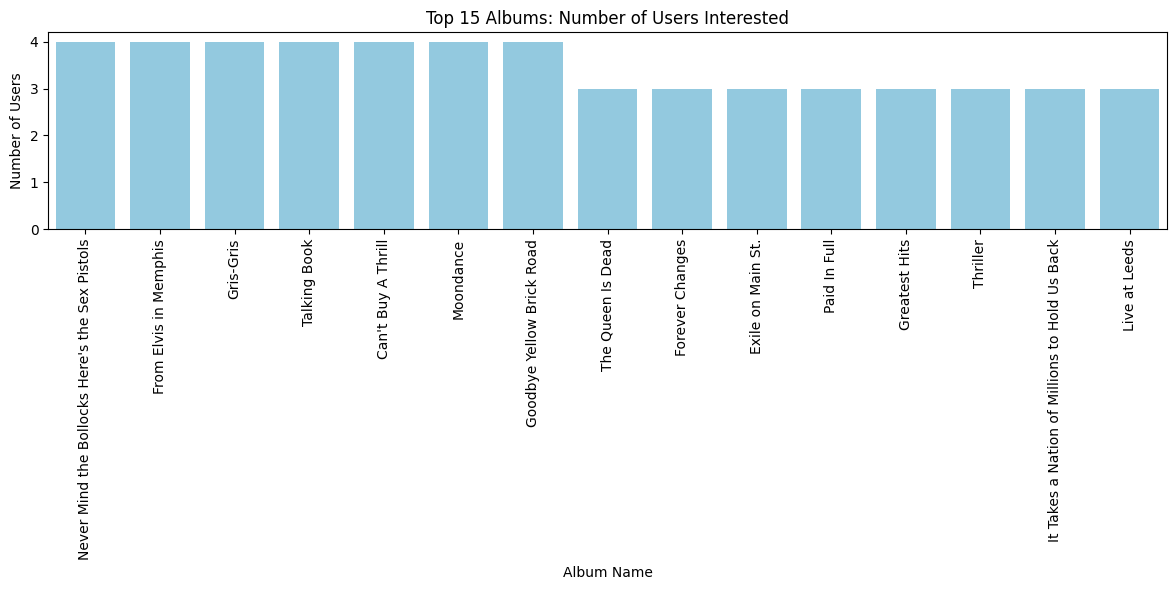

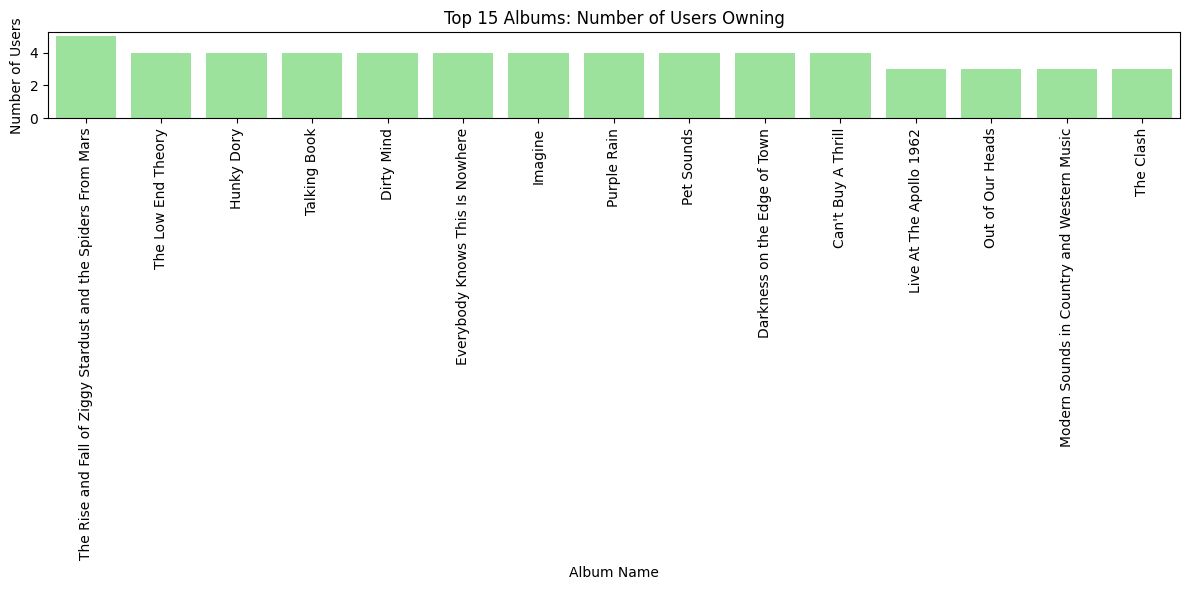

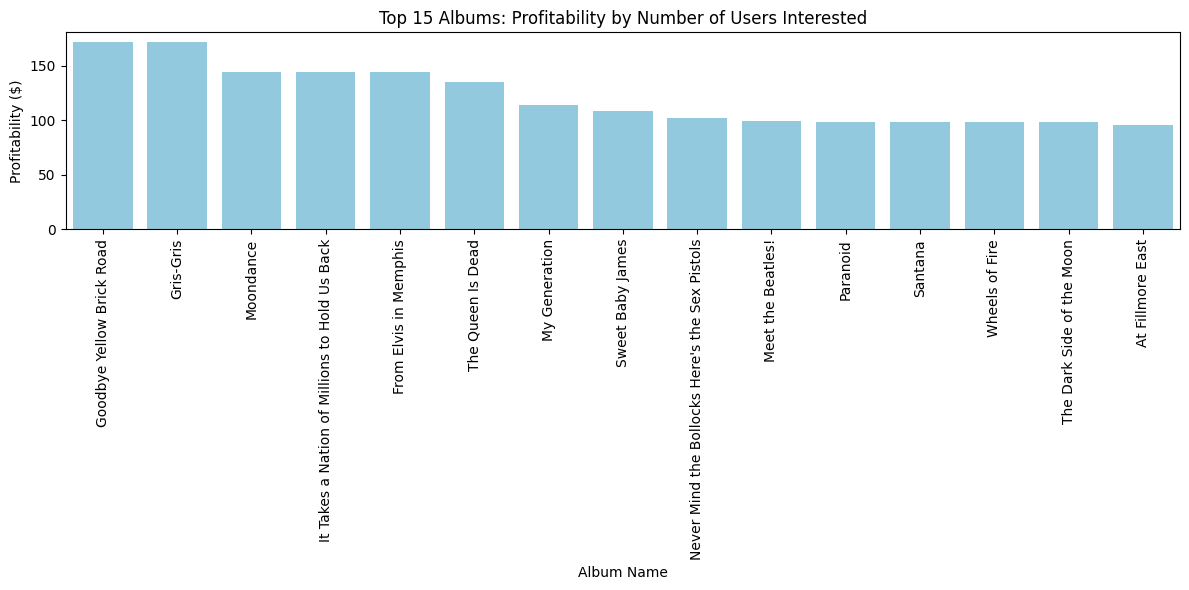

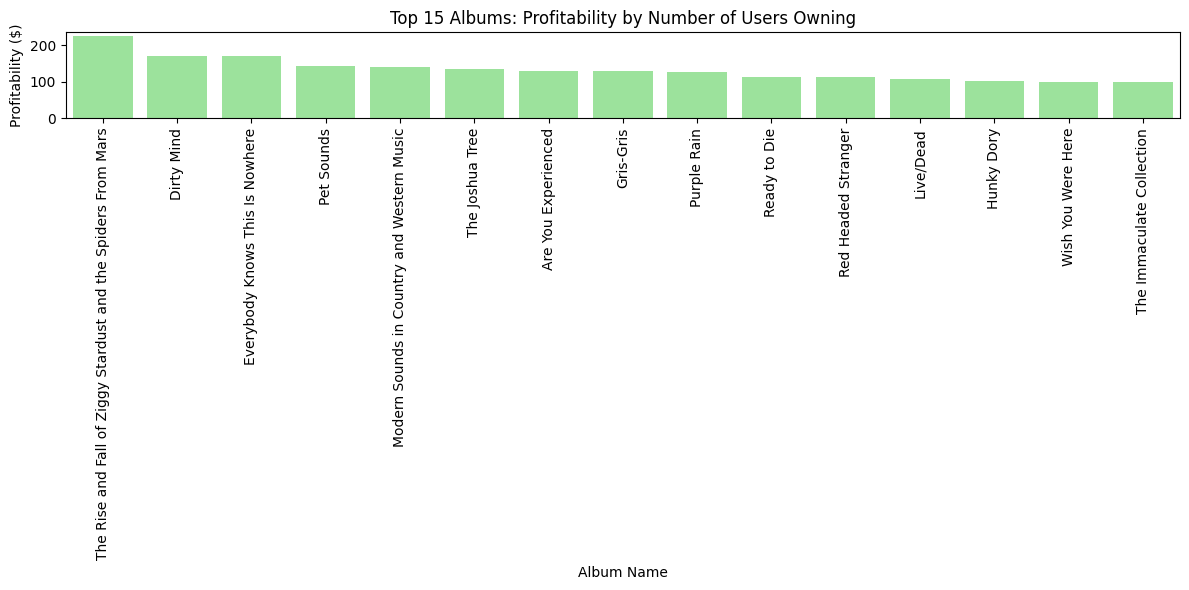

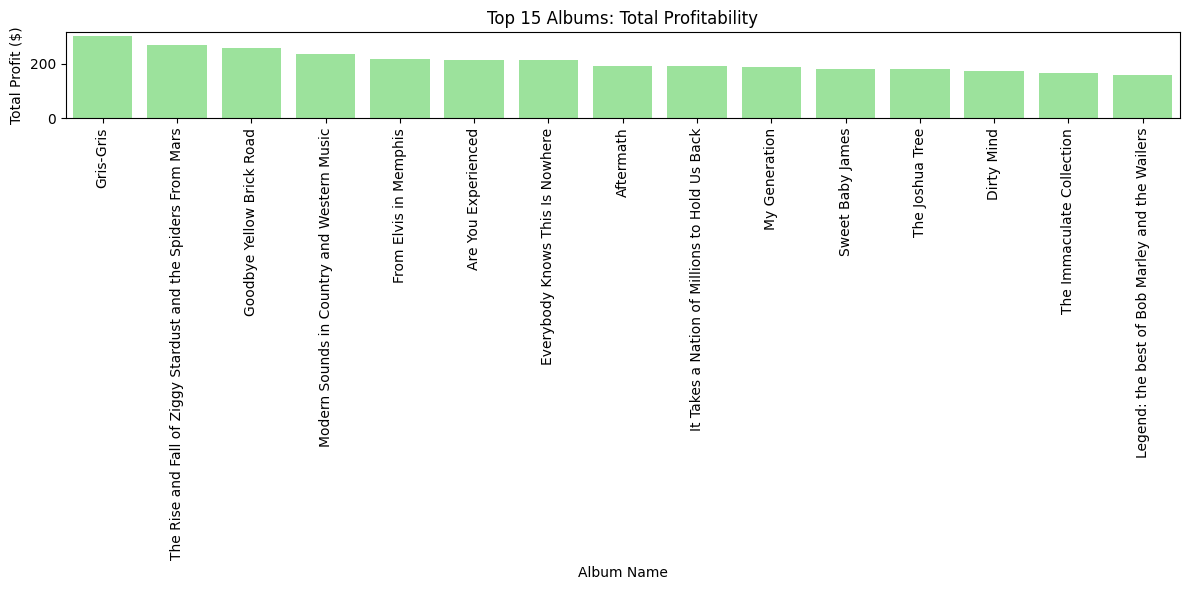

In [ ]:
# Top 15 albums by 'wanted_by' count
top_wanted_by = about_numbers.sort_values('wanted_by', ascending=False).head(15)

# Visualize 'wanted_by' count for the top 15 albums
plt.figure(figsize=(12, 6))
sns.barplot(data=top_wanted_by, x='album_name', y='wanted_by', color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Album Name')
plt.ylabel('Number of Users')
plt.title('Top 15 Albums: Number of Users Interested')
plt.tight_layout()
plt.show()

# Top 15 albums by 'owned_by' count
top_owned_by = about_numbers.sort_values('owned_by', ascending=False).head(15)

# Visualize 'owned_by' count for the top 15 albums
plt.figure(figsize=(12, 6))
sns.barplot(data=top_owned_by, x='album_name', y='owned_by', color='lightgreen')
plt.xticks(rotation=90)
plt.xlabel('Album Name')
plt.ylabel('Number of Users')
plt.title('Top 15 Albums: Number of Users Owning')
plt.tight_layout()
plt.show()

# Top 15 albums by 'profitability (by wanted)'
top_future_profitability = about_numbers.sort_values('profitability (by wanted)', ascending=False).head(15)

# Visualize 'profitability (by wanted)' for the top 15 albums
plt.figure(figsize=(12, 6))
sns.barplot(data=top_future_profitability, x='album_name', y='profitability (by wanted)', color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Album Name')
plt.ylabel('Profitability ($)')
plt.title('Top 15 Albums: Profitability by Number of Users Interested')
plt.tight_layout()
plt.show()

# Top 15 albums by 'profitability (by owned)'
top_current_profitability = about_numbers.sort_values('profitability (by owned)', ascending=False).head(15)

# Visualize 'profitability (by owned)' for the top 15 albums
plt.figure(figsize=(12, 6))
sns.barplot(data=top_current_profitability, x='album_name', y='profitability (by owned)', color='lightgreen')
plt.xticks(rotation=90)
plt.xlabel('Album Name')
plt.ylabel('Profitability ($)')
plt.title('Top 15 Albums: Profitability by Number of Users Owning')
plt.tight_layout()
plt.show()

# Top 15 albums by 'total_profit'
top_total_profit = about_numbers.sort_values('total_profit', ascending=False).head(15)

# Visualize 'total_profit' for the top 15 albums
plt.figure(figsize=(12, 6))
sns.barplot(data=top_total_profit, x='album_name', y='total_profit', color='lightgreen')
plt.xticks(rotation=90)
plt.xlabel('Album Name')
plt.ylabel('Total Profit ($)')
plt.title('Top 15 Albums: Total Profitability')
plt.tight_layout()
plt.show()

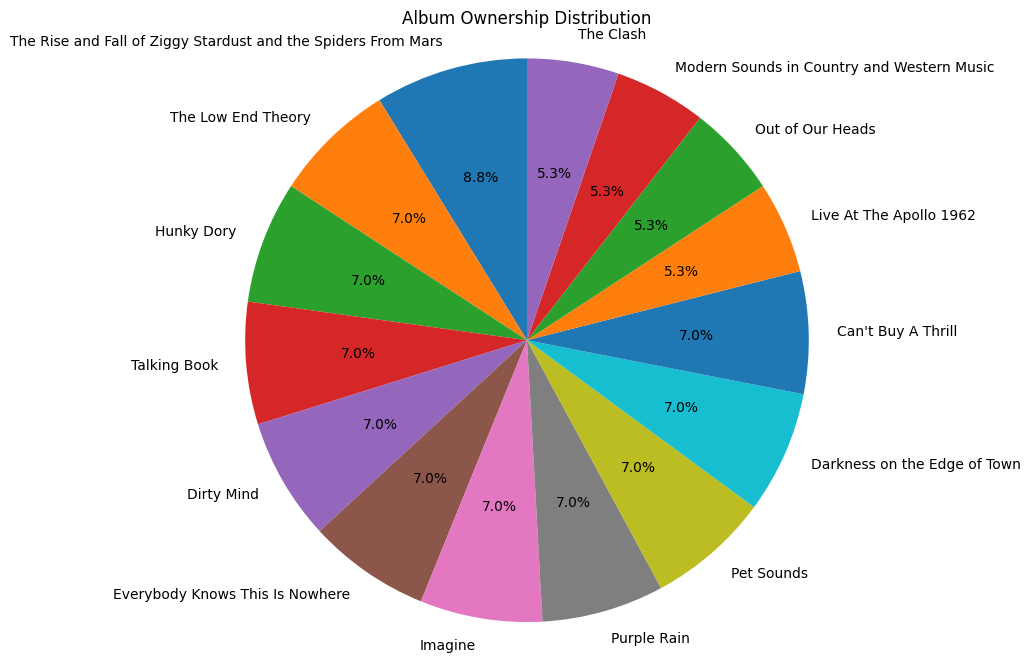

In [ ]:
# Number of users owning each album
album_ownership = about_numbers[['album_name', 'owned_by']].sort_values('owned_by', ascending=False).head(15)

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(album_ownership['owned_by'], labels=album_ownership['album_name'], autopct='%1.1f%%', startangle=90)
plt.title('Album Ownership Distribution')
plt.axis('equal')
plt.show()

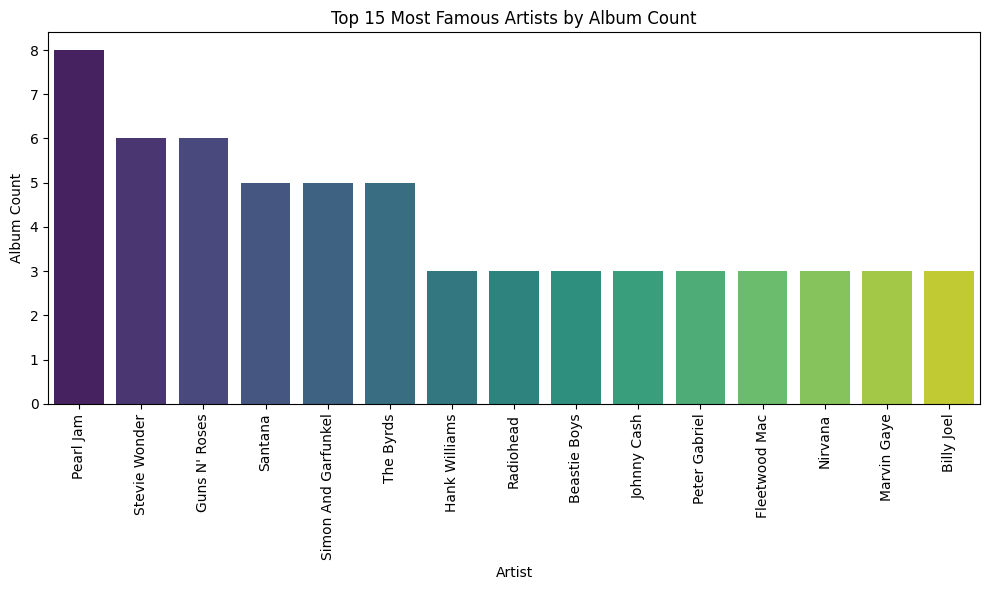

In [ ]:
# Bar plot of the top 15 artists and their album counts
plt.figure(figsize=(10, 6))
sns.barplot(data=top_artists_data, x='Artist Name', y='Album Count', palette='viridis')
plt.xlabel('Artist')
plt.ylabel('Album Count')
plt.title('Top 15 Most Famous Artists by Album Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# στ. Time series analysis

(στ.) Έστω το synthetic time series dataset στο επόμενο κελί που έχει την χαμηλότερη τιμή που πωλείται ένας δίσκος κάθε μέρα, αναπαραστήστε την χρονοσειρά και το decompose της σε trend, seasonality και residuals [διάλεξη και lab time series].

In [ ]:
date_rng = pd.date_range(start='1/1/2018', end='12/31/2022', freq='D')
val=40+15*np.tile(np.sin(np.linspace(-np.pi, np.pi, 365)),5)
val=np.append(val,val[1824])+5*np.random.rand(1826)
series = pd.DataFrame({
    'values': val
}, index=pd.DatetimeIndex(date_rng))
series.plot()
#series.to_csv('gdrive/My Drive/File_series.csv', index=True, header=True)

## Time series analysis

Create dictionary with old prices of an album using data from DB

In [ ]:
history = DB_select_price_history(17)

dates = []
prices = []
for item in history:
  dates.append(datetime.strptime(item[0], '%Y-%m-%d').date())
  prices.append(item[1])

data = {}
for key in dates:
    for value in prices:
        data[key] = value
        prices.remove(value)
        break

Create time series using the dictionary 'data' created above

In [ ]:
series = pd.Series(data)

Plot the series for visual representation

<Axes: >

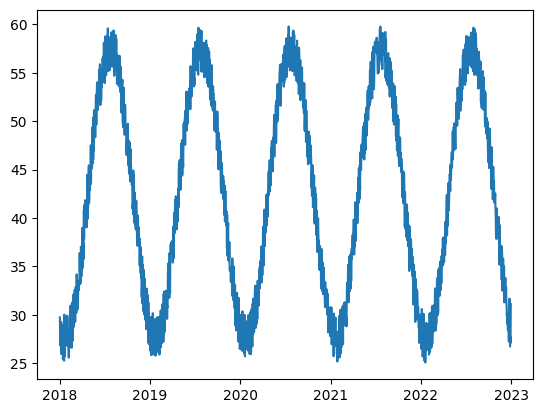

In [ ]:
series.plot()

Plot the series decompose using the additive model

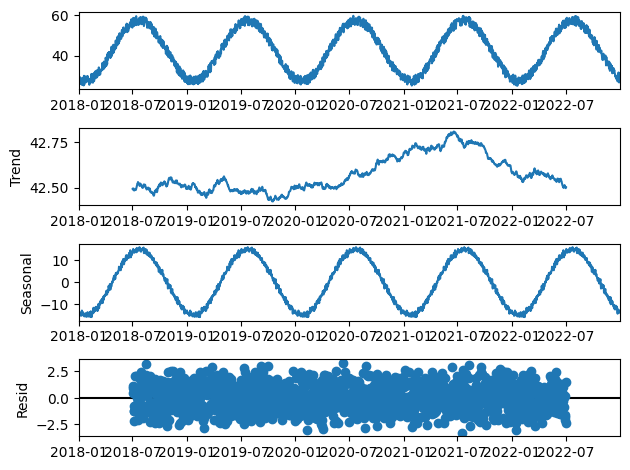

In [ ]:
result = seasonal_decompose(series, model='additive',period=365)
result.plot()
pyplot.show()

# ζ. ARIMA

(ζ.) Χωρίστε τα data της χρονοσειράς σε 66% training και 34% testing, εκπαιδεύστε ένα ARIMA μοντέλο στο training split το οποίο να προβλέπει την χαμηλότερη τιμή που θα πωλείται ένας δίσκος την επόμενη ημέρα  και αξιολογήστε την απόδοση του στο testing split [διάλεξη και lab time series].

### Autocorrelation

Using 80%/ 20%

Create the training and testing data samples

In [ ]:
Values = series.values
size = int(len(Values) * 0.80)
size2 = int(len(Values) * 0.20)
training = Values[0:size]
testing = Values[0:size2]
history = [i for i in training]
predictions = list()

Plot the autocorrelation graph

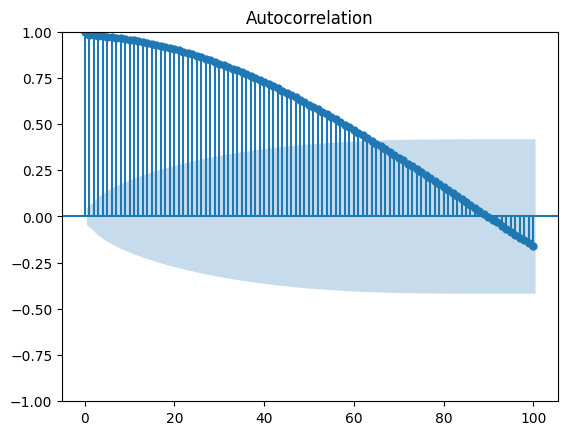

In [ ]:
plot_acf(series, lags=100)
pyplot.show()

## Moving average

Calculate moving average for training data sample

In [ ]:
window_size = 7
i = 0
moving_averages = []

while i < len(training) - window_size:
  window_average = round(np.sum(training[i:i+window_size]) / window_size, 2)
  moving_averages.append(window_average)
  i += 1

Plot testing data alongside moving average for comparison and calculate Root Mean Square Error for evaluation

Test RMSE: 1.756


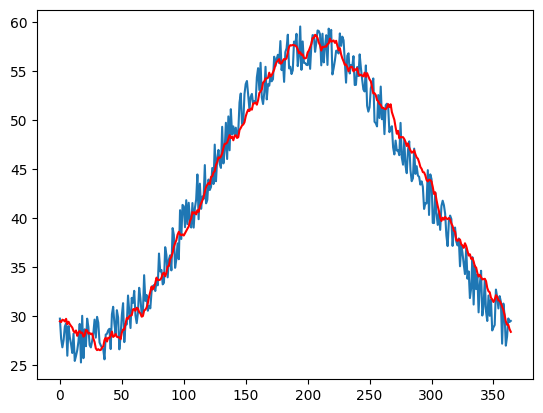

In [ ]:
i = len(training) - len(testing) - 7
end = len(training)
rmse = sqrt(mean_squared_error(testing, moving_averages[i:i+end]))
print('Test RMSE: %.3f' % rmse)
pyplot.plot(testing)
pyplot.plot(moving_averages[i:i+end], color='red')
pyplot.show()

## ARIMA

Train ARIMA model and make predictions

In [ ]:
for t in range(len(testing)):
	model = sm.tsa.arima.ARIMA(history, order=(4,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = testing[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=28.925051, expected=29.740000
predicted=29.044885, expected=27.700000
predicted=28.695884, expected=26.810000
predicted=28.355857, expected=27.550000
predicted=28.074641, expected=28.940000
predicted=28.025028, expected=29.270000
predicted=28.219990, expected=25.950000
predicted=27.679205, expected=28.970000
predicted=28.221930, expected=27.840000
predicted=28.120024, expected=27.140000
predicted=27.585803, expected=26.230000
predicted=27.295192, expected=28.200000
predicted=27.540378, expected=25.420000
predicted=26.765718, expected=25.930000
predicted=26.419033, expected=26.510000
predicted=26.497586, expected=27.420000
predicted=26.570670, expected=29.200000
predicted=27.279463, expected=25.260000
predicted=26.883225, expected=30.030000
predicted=27.944439, expected=25.700000
predicted=27.483958, expected=28.650000
predicted=27.572763, expected=26.920000
predicted=27.598215, expected=29.740000
predicted=28.047338, expected=28.890000
predicted=28.393761, expected=27.040000


Plot testing data and predictions for comparison and calculate Root Mean Square Error to evaluate accuracy of predictions

Test RMSE: 1.697


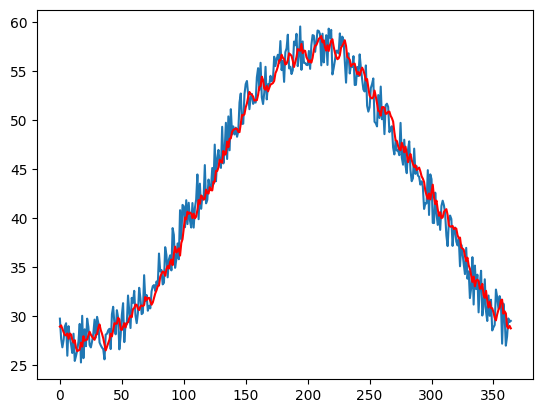

In [ ]:
rmse = sqrt(mean_squared_error(testing, predictions))
print('Test RMSE: %.3f' % rmse)
pyplot.plot(testing)
pyplot.plot(predictions, color='red')
pyplot.show()

### Find best p, q, d

Train ARIMA model with given order parameters

In [ ]:
def evaluate_arima_model(Values, arima_order):
  # prepare training dataset
  train_size = int(len(Values) * 0.76)
  training, testing = Values[0:train_size], Values[train_size:]
  history = [x for x in training]
  # make predictions
  predictions = list()
  for t in range(len(testing)):
    model = sm.tsa.arima.ARIMA(history, order=arima_order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = testing[t]
    history.append(obs)
  error = mean_squared_error(testing, predictions)
  return error

Create order parameter combinations

In [ ]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float64')
    print(dataset)
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA:%s MSE=%.3f' % (best_cfg, best_score))

Make arrays with possible numbers for ARIMA model parameters p,d,q

In [ ]:
evaluate_models(series.to_numpy(), [1,3,5,7],[1,2,3],[1,2,3])

# η. Graph mining

(η.) Με χρήση κάποιας graph mining μετρικής πάνω στον γράφο του community να προτείνετε σε κάποιον user έναν δίσκο που δεν έχει επιλέξει [διάλεξη graph mining].

## Build graph from DB

Build graph from DB for user connections

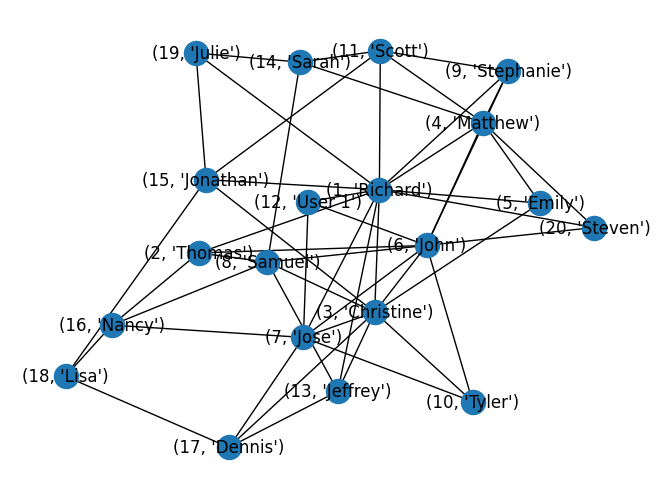

In [ ]:
users = DB_select_all_users()
labels = [(x[0], x[1]) for x in users]

G = nx.Graph()
G.add_nodes_from(labels)

edges = set()
for user in labels:
    friends = DB_select_user_friends(user[0])
    for friend in friends:
        edges.add((user, friend))

G.add_edges_from(edges)
nx.draw(G, with_labels=True)

## Find clique for user

In [ ]:
users =  [(x[0], x[1]) for x in DB_select_all_users()]
df_users = pd.DataFrame(users, columns=['id','Name'])
df_users

,id,Name
0,1,Richard
1,2,Thomas
2,3,Christine
3,4,Matthew
4,5,Emily
5,6,John
6,7,Jose
7,8,Samuel
8,9,Stephanie
9,10,Tyler


Find Cliques

In [ ]:
df_clique = pd.DataFrame(nx.find_cliques(G))
df_clique

,0,1,2,3
0,"(8, Samuel)","(14, Sarah)",None,None
1,"(8, Samuel)","(3, Christine)","(6, John)",None
2,"(8, Samuel)","(3, Christine)","(13, Jeffrey)",None
3,"(8, Samuel)","(16, Nancy)","(2, Thomas)",None
4,"(8, Samuel)","(2, Thomas)","(6, John)",None
5,"(14, Sarah)","(4, Matthew)","(11, Scott)",None
6,"(14, Sarah)","(19, Julie)",None,None
7,"(10, Tyler)","(3, Christine)","(6, John)","(7, Jose)"
8,"(16, Nancy)","(18, Lisa)",None,None
9,"(16, Nancy)","(7, Jose)",None,None


Selected user "Richard" with id 1

In [ ]:
cliques = nx.find_cliques(G)
user = users[1] # Select user

friends = set()
for clique in cliques:
    if user in clique:
        for friend in clique:
            if friend != user:
                friends.add(friend)

In [ ]:
album_recommendations = []
for user in friends:
    for album in DB_select_user_owned_albums(user[0]):
         album_recommendations.append(album)

## What friends in selected user's clique are listening

Select albums that more than 1 people are listening

In [ ]:
df_album_recommendations = pd.DataFrame(album_recommendations, columns=['id','name','artist'])
df_album_recommendations = df_album_recommendations.groupby(df_album_recommendations.columns.tolist(),as_index=False).size()
top_albums = df_album_recommendations[(df_album_recommendations['size'] > 1)]
sorted = top_albums.sort_values(by=['size'], ascending=False)
sorted

,id,name,artist,size
52,77,Pet Sounds,The Beach Boys,3
2,9,The Immaculate Collection,Madonna,2
42,67,Nick of Time,Bonnie Raitt,2
64,94,Wish You Were Here,Pink Floyd,2
62,92,Kid A,Radiohead,2
61,87,Live At The Regal,B.B. King,2
57,82,Music From Big Pink,The Band,2
56,81,The Ultimate Collection,Patsy Cline,2
55,80,Can't Buy A Thrill,Steely Dan,2
53,78,The Rise and Fall of Ziggy Stardust and the Sp...,David Bowie,2


# θ. Genetic Algorithms

(θ.) Έστω μια σειρά από users (user_money_rates) που διαθέτουν κάποια χρηματικά ποσά και έχουν εκδηλώσει την βαθμονομημένη επιθυμία τους να αγοράσουν μια σειρά από δίσκους. Η επιθυμία εκδηλώνεται με έναν βαθμό απο 1 εως 5 για κάθε δίσκο και κάθε δίσκος έχει ένα χρηματικό κόστος (album_price). Χρησιμοποιήστε έναν γενετικό αλγόριθμο για να επιλέξει τους δίσκους που θα προτείνει στους users να αγοράσουν με σκοπό να μεγιστοποιήσουν τον συνολικό βαθμό επιθυμίας των δίσκων, δεδομένου του διαθέσιμου χρηματικού ποσού που διαθέτει ο κάθε user. Συγκρίνετε τα αποτελέσματα με μια τυχαία επιλογή δίσκων. [διάλεξη genetic algorithms].

In [ ]:
users_money = 200 + np.ceil(100*np.random.rand(100))
user_money_rates=np.empty_like(np.append(users_money[0],np.random.randint(5, size=50)+1))
for i in users_money:
  user_money_rates=np.vstack([user_money_rates,np.append(i,np.random.randint(5, size=50)+1)])
user_money_rates=np.delete(user_money_rates,(0),axis=0)

album_price=np.random.randint(50, size=100)+1
#np.savetxt("gdrive/My Drive/user_money_rates.csv", user_money_rates, delimiter=",")
#np.savetxt("gdrive/My Drive/album_price.csv", album_price, delimiter=",")

## Imports

In [ ]:
!pip install scikit-opt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sko.GA import GA
from sko.PSO import PSO
from sko.SA import SA

## Select users

In [ ]:
# select users with the most amount of wishlist albums for
users = DB_select_all_users()
wishlist_total_for_all_users = []
for user in users:
    wishlist_total_for_all_users.append({"user":user, "albums":DB_select_user_album_interests(user[0])})

In [ ]:
df_users = pd.DataFrame(users, columns = ['id','Name','Funds'])
df_users

Select users with atleast 20 albums in wishlist

In [ ]:
longest_wishlist = []
for user in wishlist_total_for_all_users:
    if len(user['albums']) > 20:
        longest_wishlist.append(user)

## Random algorithm

In [ ]:
def make_random_selections(funds, wanted_albums):

    selection_costs = []
    cost = 0
    satisfaction = 0
    selected = []

    while cost < funds and len(wanted_albums) > 0:
        selection = random.choice(wanted_albums)
        selected.append(selection)
        cost += selection[3]
        wanted_albums.remove(selection)
        if cost < funds:
            satisfaction += selection[4]

    selected.pop()

    total = 0
    for album in selected:
        total += album[3]

    return satisfaction, total, selected

In [ ]:
rand_selected = []
for user in longest_wishlist:
    albums = [x for x in user['albums']]
    user_funds = user['user'][2]
    satisfaction, cost, selected = make_random_selections(user_funds, albums)
    rand_selected.append({"user":user['user'], "selections":selected, "satisfaction":satisfaction, "budget":user_funds, "cost":cost})

In [ ]:
df_rand_selections = pd.DataFrame(rand_selected)
df_rand_selections

,user,selections,satisfaction,budget,cost
0,"(5, Emily, 297.0)","[(113, Bo Diddley / Go Bo Diddley, Bo Diddley,...",27,297.0,286.0
1,"(6, John, 232.0)","[(153, Chronicle: The 20 Greatest Hits, Creede...",33,232.0,224.0
2,"(14, Sarah, 288.0)","[(108, My Aim Is True, Elvis Costello, 17.0, 5...",36,288.0,262.0
3,"(17, Dennis, 223.0)","[(147, Never Mind the Bollocks Here's the Sex ...",22,223.0,176.0


## Genetic algorithm

In [ ]:
def make_selections(funds, wanted_albums):
    album_costs = [x[3] for x in wanted_albums]
    preferences = [x[4] for x in wanted_albums]

    def fitness(candidate):
        profit = 0
        cost = 0
        for i in range(len(candidate)):
            profit += int(candidate[i]) * preferences[i]
            cost += int(candidate[i]) * album_costs[i]
        if cost > funds:
            profit = 0
        return -profit

    ga = GA(func=fitness, n_dim=len(wanted_albums), size_pop=200, max_iter=400, prob_mut=0.001, lb=0, ub=1, precision=1)
    best_x, best_y = ga.run()
    Y_history = ga.all_history_Y

    selections = []
    total = 0
    if best_y[0] != 0:
        for i in range(len(wanted_albums)):
            if best_x[i] == 1:
                selections.append(wanted_albums[i])

        for album in selections:
            total += album[3]

    return best_x, -best_y[0], selections, Y_history, total

In [ ]:
ga_selected = []
for user in longest_wishlist:
    albums = [x for x in user['albums']]
    user_funds = user['user'][2]
    best_x, best_y, selections, Y_history, total = make_selections(user_funds, albums)
    ga_selected.append({"user":user['user'][1], "selections":selections, "satisfaction":best_y, "budget":user_funds, "cost":total})

In [ ]:
df_selections = pd.DataFrame(ga_selected)
df_selections

,user,selections,satisfaction,budget,cost
0,"(5, Emily, 297.0)","[(26, Rocks, Aerosmith, 22.0, 4), (36, What's ...",57,297.0,296.0
1,"(6, John, 232.0)","[(9, The Immaculate Collection, Madonna, 29.0,...",50,232.0,221.0
2,"(14, Sarah, 288.0)","[(8, Deja Vu, Crosby, Stills, Nash and Young, ...",53,288.0,286.0
3,"(17, Dennis, 223.0)","[(45, The Birth Of Soul, Ray Charles, 13.0, 3)...",44,223.0,219.0


## Comparissons

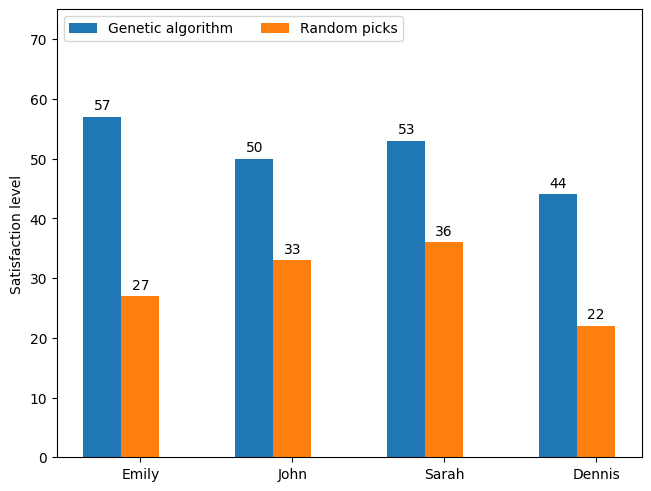

In [ ]:
users = df_rand_selections['user'].to_list()
ga_satisfaction = df_selections['satisfaction'].to_list()
rand_satisfaction = df_rand_selections['satisfaction'].to_list()
users = [x[1] for x in users]

satisfactions = {
    'Genetic algorithm': ga_satisfaction,
    'Random picks': rand_satisfaction
}

x = np.arange(len(users))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in satisfactions.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Satisfaction level')
# ax.set_title('Satisfaction levels for ')
ax.set_xticks(x + width, users)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 75)

plt.show()

In [ ]:
total_ga_satisfaction = 0
for item in ga_satisfaction:
    total_ga_satisfaction += item

total_rand_satisfaction = 0
for item in rand_satisfaction:
    total_rand_satisfaction += item

improvement = total_ga_satisfaction / total_rand_satisfaction * 100 - 100

print(f'{improvement}% total improvemend over random picks')

72.8813559322034% total improvemend over random picks


# Απαλλακτική (wip)


## PSO

In [ ]:
def make_selections_PSO(funds, wanted_albums):
    album_costs = [x[3] for x in wanted_albums]
    preferences = [x[4] for x in wanted_albums]

    def fitness(candidate):
        # binary = '{0:b}'.format(int(candidate[0]))
        binary = '{0:b}'.format(round(candidate[0]))
        while len(binary) < len(wanted_albums):
            binary = '0'+binary

        satisfaction = 0
        cost = 0
        for i in range(len(binary)):
            digit = int(binary[i])
            satisfaction += digit * preferences[i]
            cost += digit * album_costs[i]

        if cost > funds:
            return 0

        return -satisfaction

    pso = PSO(func=fitness, n_dim=1, pop=500, max_iter=150, lb=0, ub=(2**len(wanted_albums))-1, w=0.8, c1=0.5, c2=0.5)
    best_x, best_y = pso.run()

    best_x_binary = '{0:b}'.format(round(best_x[0]))
    while len(best_x_binary) < len(wanted_albums):
        best_x_binary = '0'+best_x_binary

    selections = []
    for i in range(len(wanted_albums)):
        if best_x_binary[i] == '1':
            selections.append(wanted_albums[i])

    total = 0
    for album in selections:
        total += album[3]

    return best_x, best_y, selections, total

In [ ]:
PSO_selected = []
for user in longest_wishlist:
    albums = [x for x in user['albums']]
    user_funds = user['user'][2]
    best_x, best_y, selections, total = make_selections_PSO(user_funds, albums)
    PSO_selected.append({"user":user['user'], "selections":selections, "satisfaction":-best_y[0], "budget":user_funds, "cost":total})

In [ ]:
df_PSO_selections = pd.DataFrame(PSO_selected)
df_PSO_selections

,user,selections,satisfaction,budget,cost
0,"(5, Emily, 297.0)","[(7, Nebraska, Bruce Springsteen, 36.0, 3), (2...",54.0,297.0,292.0
1,"(6, John, 232.0)","[(19, Black Sabbath, Black Sabbath, 21.0, 4), ...",42.0,232.0,224.0
2,"(14, Sarah, 288.0)","[(8, Deja Vu, Crosby, Stills, Nash and Young, ...",51.0,288.0,277.0
3,"(17, Dennis, 223.0)","[(45, The Birth Of Soul, Ray Charles, 13.0, 3)...",34.0,223.0,214.0


## SA

In [ ]:
def make_selections_SA(funds, wanted_albums):
    album_costs = [x[3] for x in wanted_albums]
    preferences = [x[4] for x in wanted_albums]

    def fitness(candidate):
        binary = '{0:b}'.format(round(candidate[0]))
        while len(binary) < len(wanted_albums):
            binary = '0'+binary

        satisfaction = 0
        cost = 0
        for i in range(len(binary)):
            digit = int(binary[i])
            satisfaction += digit * preferences[i]
            cost += digit * album_costs[i]

        if cost > funds:
            return 0

        return -satisfaction

    sa = SA(func=fitness, x0=[1], T_max=100, T_min=1e-7, L=300, max_stay_counter=150, lb = 0, ub = (2**len(wanted_albums))-1)
    best_x, best_y = sa.run()

    best_x_binary = '{0:b}'.format(round(best_x[0]))
    while len(best_x_binary) < len(wanted_albums):
        best_x_binary = '0'+best_x_binary

    selections = []
    for i in range(len(wanted_albums)-1):
        if best_x_binary[i] == '1':
            selections.append(wanted_albums[i])

    total = 0
    for album in selections:
        total += album[3]

    return best_x, best_y, selections, total

In [ ]:
SA_selected = []
for user in longest_wishlist:
    albums = [x for x in user['albums']]
    user_funds = user['user'][2]
    best_x, best_y, selections, total = make_selections_SA(user_funds, albums)
    SA_selected.append({"user":user['user'], "selections":selections, "satisfaction":-best_y, "budget":user_funds, "cost":total})

In [ ]:
df_SA_selections = pd.DataFrame(SA_selected)
df_SA_selections

,user,selections,satisfaction,budget,cost
0,"(5, Emily, 297.0)","[(26, Rocks, Aerosmith, 22.0, 4), (36, What's ...",57,297.0,258.0
1,"(6, John, 232.0)","[(21, Let It Bleed, The Rolling Stones, 12.0, ...",37,232.0,208.0
2,"(14, Sarah, 288.0)","[(8, Deja Vu, Crosby, Stills, Nash and Young, ...",49,288.0,281.0
3,"(17, Dennis, 223.0)","[(45, The Birth Of Soul, Ray Charles, 13.0, 3)...",37,223.0,219.0


## Visualize

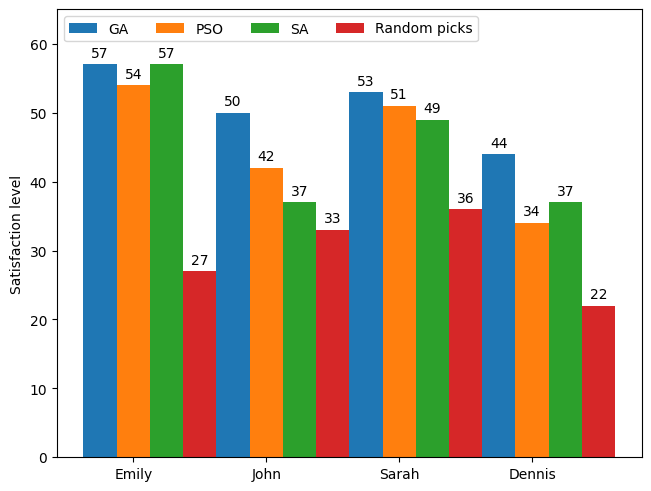

<Figure size 300x300 with 0 Axes>

In [ ]:
users = df_rand_selections['user'].to_list()
ga_satisfaction = df_selections['satisfaction'].to_list()
rand_satisfaction = df_rand_selections['satisfaction'].to_list()
pso_satisfaction = df_PSO_selections['satisfaction'].to_list()
sa_satisfaction = df_SA_selections['satisfaction'].to_list()
users = [x[1] for x in users]

satisfactions = {
    'GA': ga_satisfaction,
    'PSO': pso_satisfaction,
    'SA': sa_satisfaction,
    'Random picks': rand_satisfaction
}

x = np.arange(len(users))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in satisfactions.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Satisfaction level')
# ax.set_title('Satisfaction levels for ')
ax.set_xticks(x + width, users)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 65)
plt.figure(figsize=(3,3))
plt.show()